# Data Analysis

In the following notebooks, we will go through the implementation of each of the steps in the Machine Learning Pipeline. 

We will discuss:

1. **Data Analysis**
2. Feature Engineering
3. Feature Selection
4. Model Training
5. Obtaining Predictions / Scoring

===================================================================================================

## Predicting Renting Price of Houses

The aim of the project is to build a machine learning model to predict the rent price of homes based on data obtained from the idealista API of real real estate listings in Lisbon.


### Why is this important? 

Predicting rent prices is useful to identify fruitful investments or to determine whether the price advertised for a house is over or under-estimated.


### What is the objective of the machine learning model?

We aim to minimise the difference between the real price and the price estimated by our model. We will evaluate model performance with the:

1. mean squared error (mse)
2. root squared of the mean squared error (rmse)
3. r-squared (r2).

# Data Analysis

Let's go ahead and import the necessary libraries

In [1]:
# to handle datasets
import pandas as pd
import numpy as np
import datetime

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for the yeo-johnson transformation
import scipy.stats as stats

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# to display the plots in a nice way
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

Next, we load the dataset

In [2]:
# config
read_path = f"../data/idealista"

city = "lisbon"
operation = "rent"
date_or_unioned = "unioned"
include_geodata = True
inclue_openai = True
outlier_removal_method = None

In [3]:
def is_valid_date_format(date_string):
    try:
        datetime.datetime.strptime(date_string, "%Y-%m-%d")
        return True
    except ValueError:
        return False


if not (date_or_unioned == "unioned" or is_valid_date_format(date_or_unioned)):
    raise ValueError(
        "date_or_unioned must be 'unioned' or a valid date in the format 'YYYY-MM-DD'"
    )

# base file name
file_name = f"{date_or_unioned}-{city}-listings-for-{operation}"

if outlier_removal_method is not None:
    file_name += f"-{outlier_removal_method}"
if include_geodata:
    file_name += f"-with-geodata"
if inclue_openai:
    file_name += f"-openai"

data = pd.read_csv(
    f"{read_path}/cleaned/{operation}/{city}/{file_name}.csv", index_col="propertyCode"
)

# rows and columns of the data
data.shape

(3413, 104)

In [4]:
data.columns.to_list()

['thumbnail',
 'externalReference',
 'numPhotos',
 'floor',
 'price',
 'propertyType',
 'operation',
 'size',
 'rooms',
 'bathrooms',
 'address',
 'province',
 'municipality',
 'district',
 'country',
 'latitude',
 'longitude',
 'showAddress',
 'url',
 'distance',
 'description',
 'hasVideo',
 'status',
 'newDevelopment',
 'hasLift',
 'priceByArea',
 'detailedType',
 'suggestedTexts',
 'hasPlan',
 'has3DTour',
 'has360',
 'hasStaging',
 'topNewDevelopment',
 'topPlus',
 'neighborhood',
 'newDevelopmentFinished',
 'snapshotDate',
 'formerPrice',
 'priceChange',
 'isPriceLowered',
 'hasParkingSpace',
 'isParkingSpaceIncludedInPrice',
 'parkingSpacePrice',
 'totalPrice',
 'distanceToCityCenter',
 'distanceToNearestMall',
 'nearestMallName',
 'distanceToNearestTrain',
 'nearestTrainName',
 'distanceToNearestFair',
 'nearestFairName',
 'distanceToNearestPark',
 'nearestParkName',
 'distanceToNearestMarket',
 'nearestMarketName',
 'distanceToNearestMetro',
 'nearestMetroName',
 'distanceToNe

The columns in this dataset are not all interesting so we will make a preliminary selection of columns:

In [ ]:
features = [
    "floor",
    "propertyType",
    "size",
    "rooms",
    "bathrooms",
    "municipality",
    "district",
    "latitude",
    "longitude",
    "showAddress",
    "hasVideo",
    "status",
    "newDevelopment",
    "hasLift",
    "hasPlan",
    "has3DTour",
    "has360",
    "hasStaging",
    "topNewDevelopment",
    "topPlus",
    "newDevelopmentFinished",
    "isPriceLowered",
    "hasParkingSpace",
    "isParkingSpaceIncludedInPrice",
    "distanceToCityCenter",
    "distanceToNearestMall",
    "nearestMallName",
    "distanceToNearestTrain",
    "nearestTrainName",
    "distanceToNearestFair",
    "nearestFairName",
    "distanceToNearestPark",
    "nearestParkName",
    "distanceToNearestMarket",
    "nearestMarketName",
    "distanceToNearestMetro",
    "nearestMetroName",
    "distanceToNearestViewpoint",
    "nearestViewpointName",
    "distanceToNearestPlayground",
    "nearestPlaygroundName",
    "distanceToNearestBus",
    "nearestBusName",
    "distanceToNearestTram",
    "nearestTramName",
    "hasSwimmingPool",
    "hasBalcony",
    "hasGarage",
    "hasParking",
    "hasAirConditioning",
    "hasClotheslineSpace",
    "hasBuiltInWardrobes",
    "hasDishwasher",
    "hasWashingMachine",
    "hasDryer",
    "hasElevator",
    "isFurnished",
    "isPetFriendly",
    "isSmokingAllowed",
    "isWheelchairAccessible",
    "hasGarden",
    "hasFireplace",
    "hasAlarmSystem",
    "hasCityViews",
    "hasWaterViews",
    "isLuxury",
    "isTemporaryContract",
    "isLongTermContract",
    "isStudentFriendly",
    "energyEfficiencyRating",
    "hasHomeAppliances",
    "hasOven",
    "hasMicrowave",
    "hasRefrigerator",
    "hasStove",
    "hasTerrace",
    "hasStorageRoom",
    "hasInternetIncluded",
    "hasCableTVIncluded",
    "hasSmartHomeFeatures",
    "hasCCTV",
    "hasGym",
    "isNewlyRenovated",
    "hasModernFinish",
]
target = ["totalPrice"]

In [6]:
data = data[features + target]

In [7]:
from sklearn.model_selection import train_test_split

# Let's separate into train and test set
data_train, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data["municipality"])

In [8]:
data_train.shape, data_test.shape

((2730, 85), (683, 85))

The house price dataset contains 2542 rows, that is, real estate listings, and 40 columns, i.e., variables.

## Analysis

**We will analyse the following:**

1. The target variable
2. Variable types (categorical and numerical)
3. Missing data
4. Numerical variables
    - Discrete
    - Continuous
    - Distributions
    - Transformations

5. Categorical variables
    - Cardinality
    - Rare Labels
    - Special mappings
    
6. Additional Reading Resources

## Target

Let's begin by exploring the target distribution.

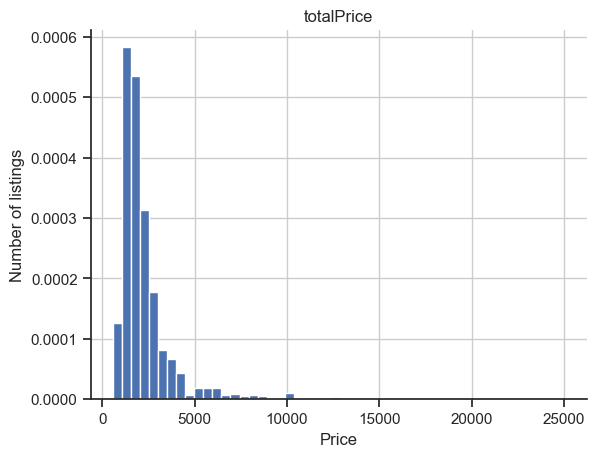

In [9]:
# histogran to evaluate target distribution

data_train[target].hist(bins=50, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Price')
plt.show()

We can see that the target is continuous, and the distribution is skewed towards the right.

We can improve the value spread with a mathematical transformation.

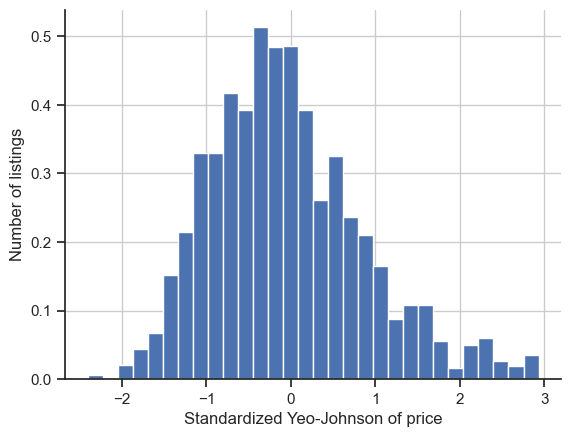

In [10]:
from sklearn.preprocessing import PowerTransformer
from feature_engine.transformation import LogTransformer
from sklearn.preprocessing import StandardScaler

temp = data_train.copy()
pt = LogTransformer()
temp['totalPrice'] = pt.fit_transform(data_train[target])
ss = StandardScaler()
temp['totalPrice'] = ss.fit_transform(temp['totalPrice'].values.reshape(-1,1))
# temp['totalPrice'] = pt.fit_transform(data_train[target].values.reshape(-1,1))
temp = temp[abs(temp['totalPrice']) <= 3]
temp['totalPrice'].hist(bins=30, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Standardized Yeo-Johnson of price')
plt.show()


In [11]:
temp['totalPrice']

propertyCode
33927611   -0.574784
33818215   -0.561307
33921433   -0.406249
34009508   -0.928641
27801065    0.427180
              ...   
33857958    0.299889
33873796   -0.629610
33888919    0.018303
33934316   -1.010887
33886688   -0.193973
Name: totalPrice, Length: 2693, dtype: float64

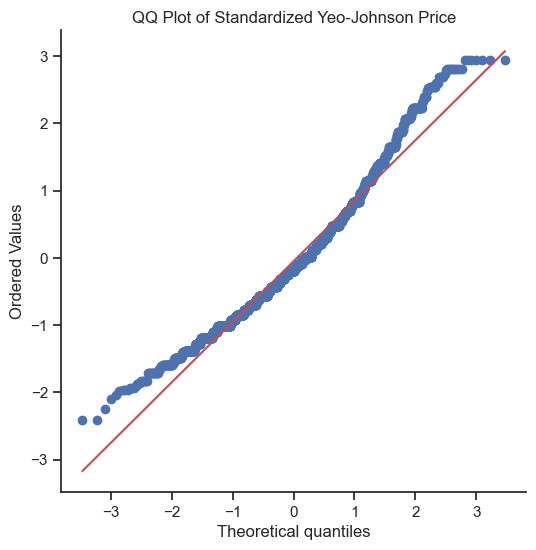

In [12]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
stats.probplot(temp["totalPrice"], dist="norm", plot=ax)
ax.set_title("QQ Plot of Standardized Yeo-Johnson Price")
plt.show()

## Variable Types

Next, let's identify the categorical and numerical variables

In [13]:
# let's identify the categorical variables
# we will capture those of type *object*

cat_vars = data_train[features].select_dtypes(include=['object']).columns.tolist()

# number of categorical variables
len(cat_vars)

16

In [14]:
# now let's identify the numerical variables

num_vars = data_train[features].select_dtypes(include=['number']).columns.tolist()

# number of numerical variables
len(num_vars)

16

# Missing values

Let's go ahead and find out which variables of the dataset contain missing values.

In [15]:
# make a list of the variables that contain missing values
vars_with_na = [var for var in data_train.columns if data_train[var].isnull().sum() > 0]

# determine percentage of missing values (expressed as decimals)
# and display the result ordered by % of missin data

data_train[vars_with_na].isnull().mean().sort_values(ascending=False)

floor       0.388278
district    0.046520
status      0.000366
dtype: float64

The floor feature has a significant amount of missing values, and other variables have a small percentage of missing observations.

This means that to train a machine learning model with this data set, we need to impute the missing data in these variables.

We can also visualize the percentage of missing values in the variables as follows:

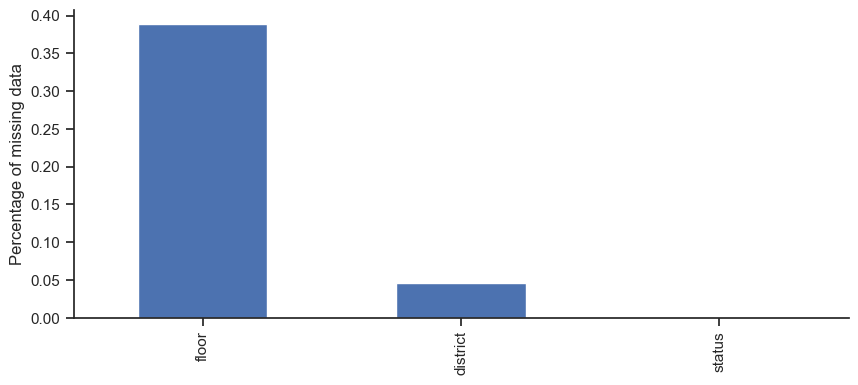

In [16]:
# plot

data_train[vars_with_na].isnull().mean().sort_values(
    ascending=False).plot.bar(figsize=(10, 4))
plt.ylabel('Percentage of missing data')

plt.show()

In [17]:
# now we can determine which variables, from those with missing data,
# are numerical and which are categorical

cat_na = [var for var in cat_vars if var in vars_with_na]
num_na = [var for var in num_vars if var in vars_with_na]

print('Number of categorical variables with na: ', len(cat_na))
print('Number of numerical variables with na: ', len(num_na))

Number of categorical variables with na:  3
Number of numerical variables with na:  0


In [18]:
num_na

[]

In [19]:
cat_na

['floor', 'district', 'status']

In [20]:
# variables to impute with the string missing
with_missing = [var for var in cat_na if data_train[var].isnull().mean() > 0.1]

# variables to impute with the most frequent category
with_mode = [var for var in cat_na if data_train[var].isnull().mean() < 0.1]

In [21]:
with_missing, with_mode

(['floor'], ['district', 'status'])

# Categorical variables

Let's go ahead and analyse the categorical variables present in the dataset.

In [22]:
print('Number of categorical variables: ', len(cat_vars))

Number of categorical variables:  16


In [23]:
# let's visualise the values of the categorical variables
data_train[cat_vars].head()

floor propertyType             municipality  \
propertyCode                                               
33927611         1         flat  São Domingos de Benfica   
33818215         1         flat  São Domingos de Benfica   
33921433       NaN         flat                  Areeiro   
34009508       NaN         flat             Misericórdia   
27801065       NaN         flat        Santa Maria Maior   

                                 district status              nearestMallName  \
propertyCode                                                                    
33927611               Estrada de Benfica   good              Galerias Teteia   
33818215                 Alto dos Moinhos   good     Centro Comercial Colombo   
33921433      Av. de Roma - Campo Pequeno   good  Centro Comercial Acquaroma    
34009508        Príncipe Real - São Bento   good                    Embaixada   
27801065               Mouraria - Castelo   good    Centro Comercial Mouraria   

             nearestTrainName                      nearestFairName  \
propertyCode                                                         
33927611            Sete Rios                         Feira da Luz   
33818215              Benfica                         Feira da Luz   
33921433         Roma Areeiro               Feira São João de Deus   
34009508               Rossio     Feira Biológica do Príncipe Real   
27801065       Santa Apolónia  Feira de Artesanato Urbano da Graça   

                                                nearestParkName  \
propertyCode                                                      
33927611                                 Jardim do Beau -Séjour   
33818215             Jardim da Rua Inocêncio Francisco da Silva   
33921433                   Jardim Fernando Pessa - Forum Lisboa   
34009508                               Jardim Fialho de Almeida   
27801065      Miradouro Sophia de Mello Breyner Andresen (Mi...   

                               nearestMarketName  nearestMetroName  \
propertyCode                                                         
33927611      Mercado Levante do Colégio Militar  Alto dos Moinhos   
33818215      Mercado Levante do Colégio Militar  Alto dos Moinhos   
33921433                    Mercado Alvalade Sul           Areeiro   
34009508                      Mercado da Ribeira              Rato   
27801065                      Mercado da Ribeira      Martim Moniz   

                                           nearestViewpointName  \
propertyCode                                                      
33927611                                    Miradouro do Calhau   
33818215                                    Miradouro do Calhau   
33921433                           Miradouro da Penha de França   
34009508                    Miradouro de São Pedro de Alcântara   
27801065      Miradouro Sophia de Mello Breyner Andresen (Mi...   

                                       nearestPlaygroundName  \
propertyCode                                                   
33927611         Parque Infantil do Largo do Conde de Bonfim   
33818215      Parque Infantil do Largo Pedro Correia Marques   
33921433             Parque Infantil do Jardim Fernando Peça   
34009508                     Parque Infantil da Praça Flores   
27801065       Parque Infantil do Jardim da Cerca da Graça 2   

                                   nearestBusName  \
propertyCode                                        
33927611                  São Domingos de Benfica   
33818215              Rua António Alçada Baptista   
33921433      Avenida João XXI / Praça de Londres   
34009508                         Plaça das Flores   
27801065                           Largo da Graça   

                                             nearestTramName  \
propertyCode                                                   
33927611      Campolide (Avenida Conselheiro Fernando Sousa)   
33818215      Campolide (Avenida Conselheiro Fernando Sousa)   
33921433                 

## Number of labels: cardinality

Let's evaluate how many different categories are present in each of the variables.

<Axes: >

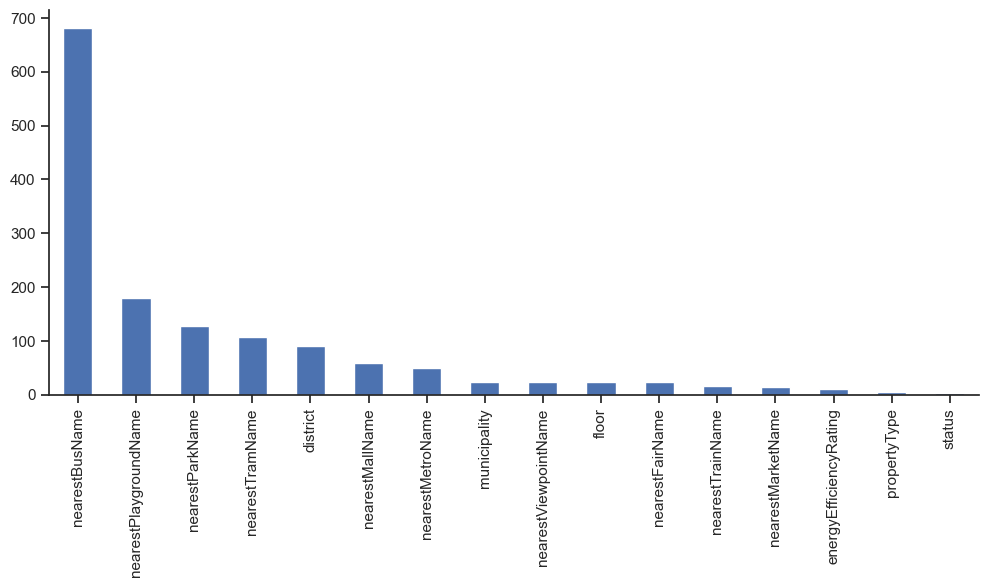

In [24]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data_train[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

Some of the categorical variables show low cardinality, this means that they have only few different labels. However, some others have very high cardinality, which makes it clear we will have to deal with them somehow.

## Relationship between missing data and Sale Price

Let's evaluate the price of the house in those observations where the information is missing. We will do this for each variable that shows missing data_train.

In [25]:
def analyse_na_value(df, var, target):

    # copy of the dataframe, so that we do not override the original data
    # see the link for more details about pandas.copy()
    # https://pandas.pydata_train.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
    df = df.copy()

    # let's make an interim variable that indicates 1 if the
    # observation was missing or 0 otherwise
    df[var] = np.where(df[var].isnull(), 1, 0)

    # let's compare the median SalePrice in the observations where data is missing
    # vs the observations where data is available

    # determine the median price in the groups 1 and 0,
    # and the standard deviation of the sale price,
    # and we capture the results in a temporary dataset
    tmp = df.groupby(var)[target].agg(['mean', 'std'])

    # plot into a bar graph
    tmp.plot(kind="barh", y="mean", legend=False,
             xerr="std", title=target, color='green')

    plt.show()

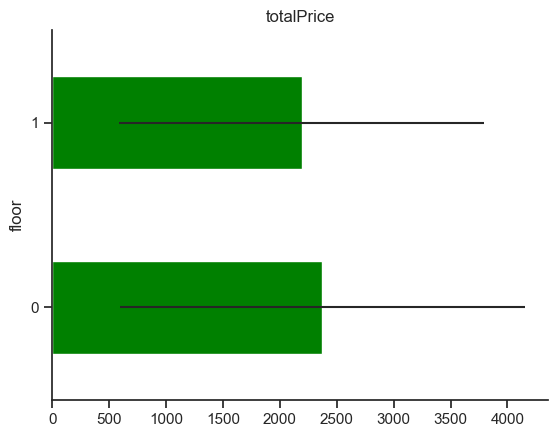

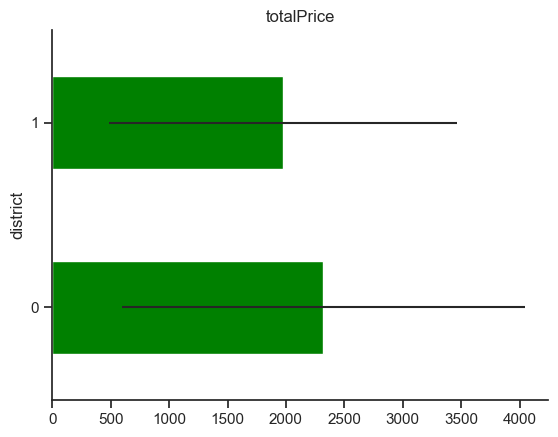

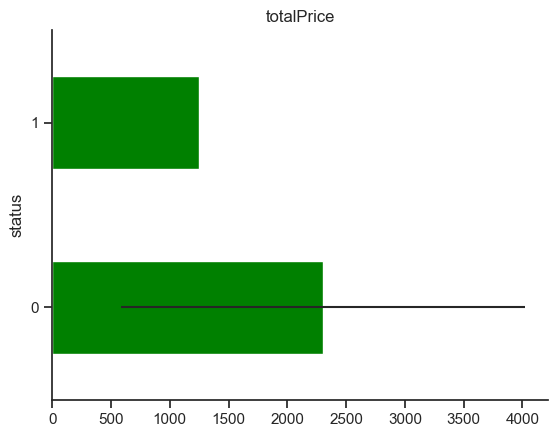

In [26]:
# let's run the function on each variable with missing data

for var in vars_with_na:
    analyse_na_value(data_train, var, 'totalPrice')

In some variables, the average rent price in houses where the information is missing, differs from the average rent price in listings where this information exists. This suggests that data being missing could be a good predictor of rent price.

In [27]:
from feature_engine.imputation import CategoricalImputer

ci = CategoricalImputer(imputation_method='frequent', variables=with_mode)
data_train = ci.fit_transform(data_train)

In [28]:
from feature_engine.imputation import CategoricalImputer

ci = CategoricalImputer(imputation_method='missing', fill_value='Missing', variables=with_missing)
data_train = ci.fit_transform(data_train)

## Rare labels:

Let's go ahead and investigate now if there are labels that are present only in a small number of houses:

In [29]:
def analyse_rare_labels(df, var, rare_perc):
    df = df.copy()

    # determine the % of observations per category
    tmp = df.groupby(var)[target[0]].count() / len(df)

    # return categories that are rare
    return tmp[tmp < rare_perc]

# print categories that are present in less than
# 1 % of the observations

for var in cat_vars:
    print(analyse_rare_labels(data_train, var, 0.01))
    print()

floor
-1    0.000366
-2    0.000366
10    0.005128
11    0.002564
12    0.001832
13    0.002198
14    0.000733
15    0.000733
16    0.000366
17    0.000733
9     0.005861
en    0.000733
ss    0.000366
st    0.005861
Name: totalPrice, dtype: float64

propertyType
penthouse    0.007326
Name: totalPrice, dtype: float64

municipality
Carnide        0.009890
Santa Clara    0.006593
Name: totalPrice, dtype: float64

district
Alfama                                    0.004396
Alto da Ajuda                             0.000366
Alto de Alcântara                         0.005128
Alto de São João - Alto do Varejão        0.007692
Alto dos Moinhos                          0.009158
Alvalade                                  0.009524
Alvito - Quinta do Jacinto                0.001465
Amoreiras                                 0.003297
Arco do Cego                              0.002198
Arneiros                                  0.005128
Av. de Roma - Campo Pequeno               0.006593
Avenida do Urugu

In [30]:
from feature_engine.encoding import RareLabelEncoder

# let's group the categories that appear in less than 1% of the data
rle = RareLabelEncoder(n_categories=1, tol=0.01, variables=cat_vars)
data_train = rle.fit_transform(data_train)

<Axes: >

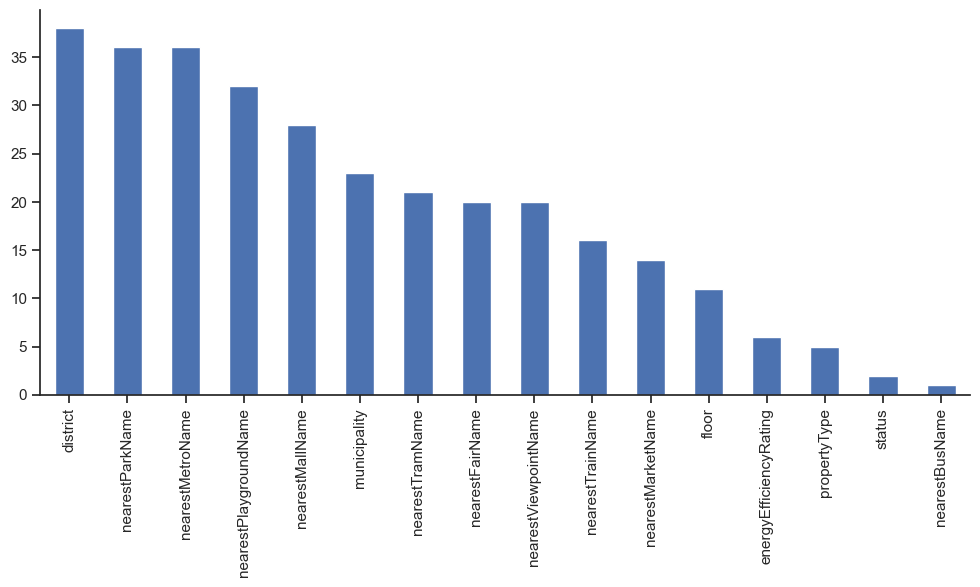

In [31]:
# we count unique categories with pandas unique() 
# and then plot them in descending order

data_train[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [32]:
cardinality = data_train[cat_vars].nunique().sort_values(ascending=False)

In [33]:
one_hot_vars = cardinality[cardinality <= 5].index.tolist()
ordinal_vars = cardinality[cardinality > 5].index.tolist()

In [34]:
ordinal_vars

['district',
 'nearestParkName',
 'nearestMetroName',
 'nearestPlaygroundName',
 'nearestMallName',
 'municipality',
 'nearestTramName',
 'nearestFairName',
 'nearestViewpointName',
 'nearestTrainName',
 'nearestMarketName',
 'floor',
 'energyEfficiencyRating']

Some of the categorical variables show multiple labels that are present in less than 1% of the houses. 

Labels that are under-represented in the dataset tend to cause over-fitting of machine learning models. 

That is why we want to remove them.

Finally, we want to explore the relationship between the categories of the different variables and the house sale price:

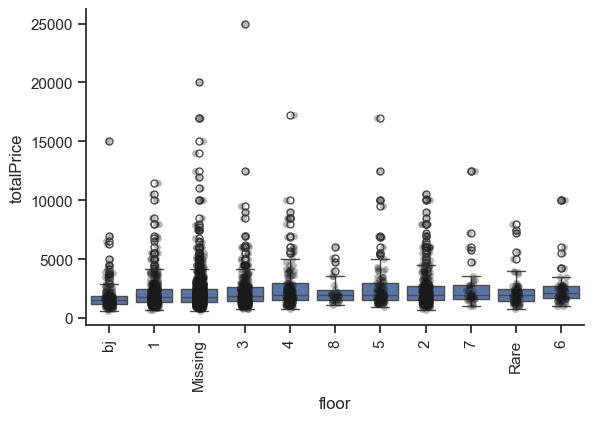

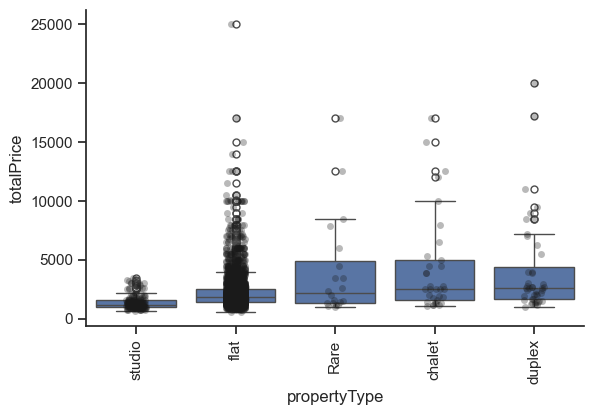

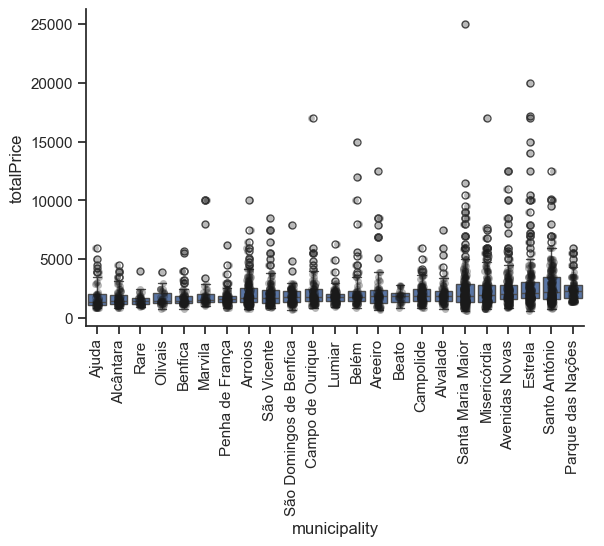

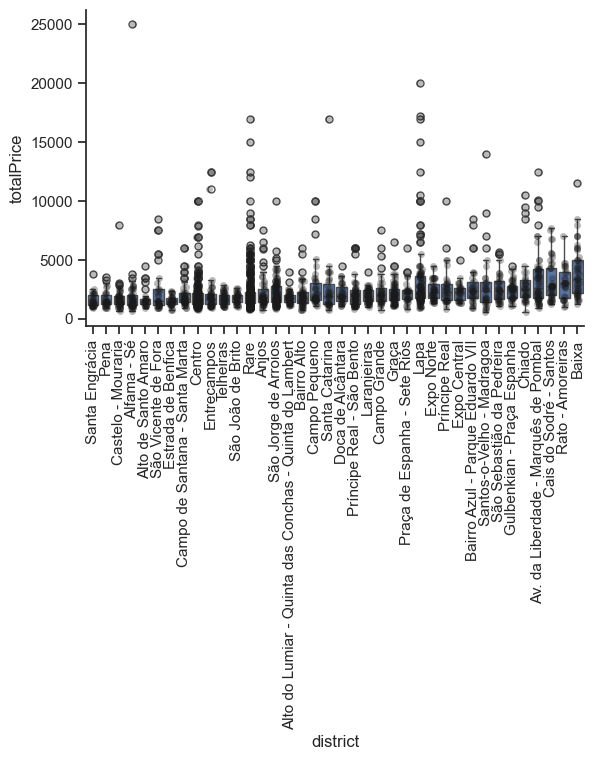

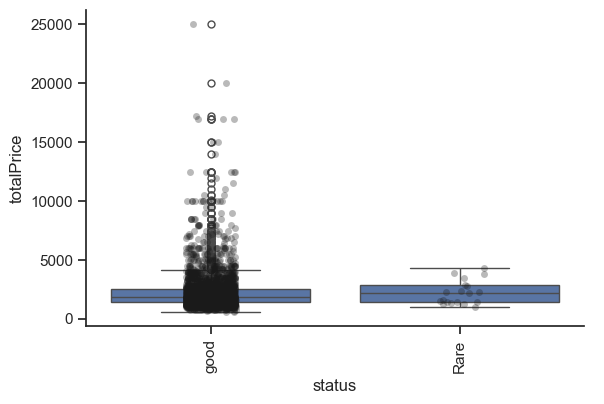

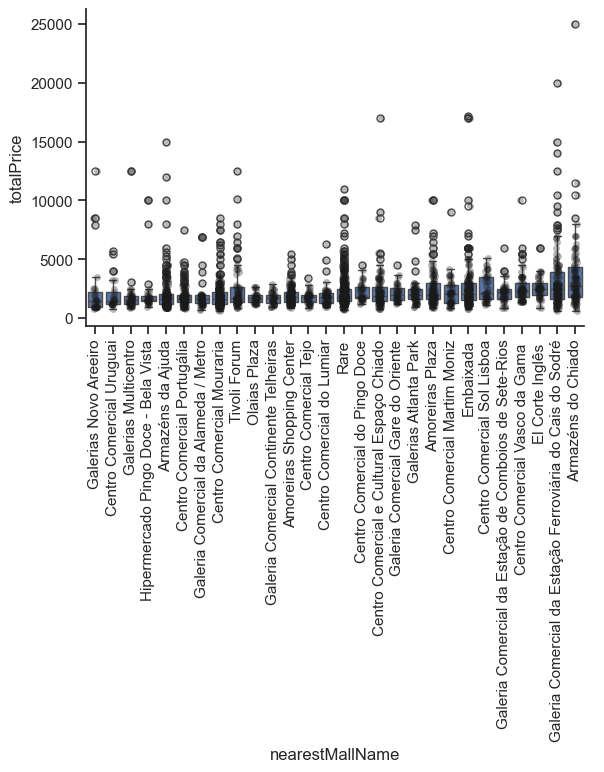

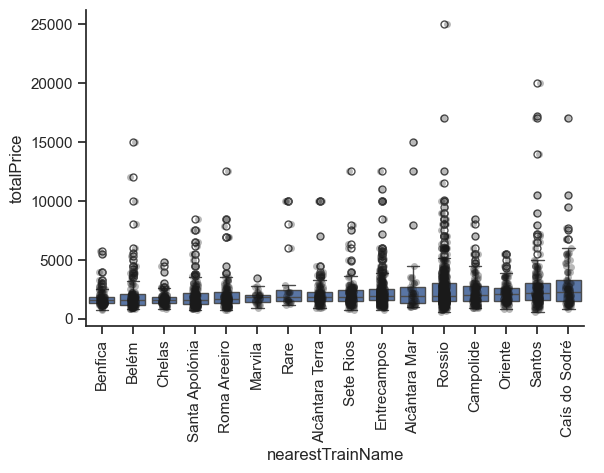

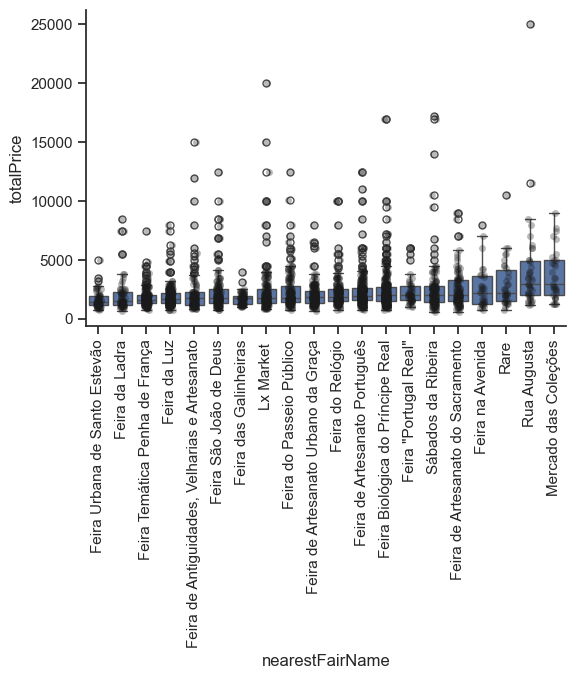

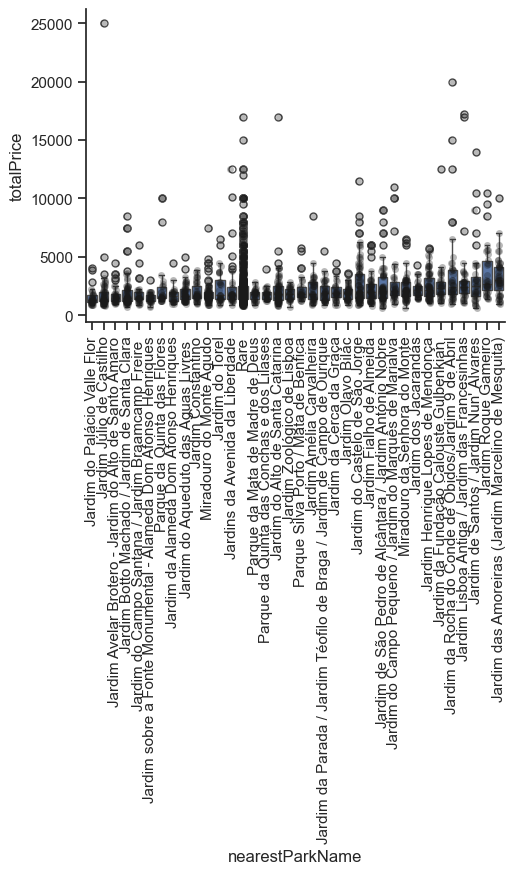

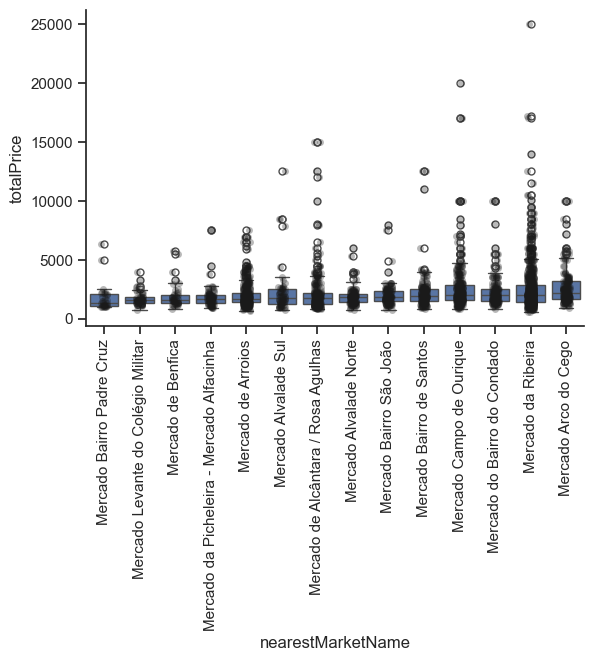

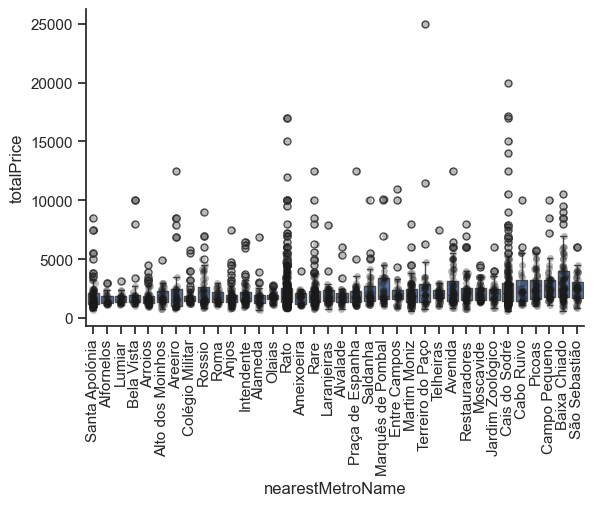

) missing from font(s) Arial.housing-prices/.venv/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: Glyph 13 (
  self._figure.tight_layout(*args, **kwargs)
) missing from font(s) Arial.housing-prices/.venv/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 13 (
  fig.canvas.draw()
) missing from font(s) Arial.housing-prices/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


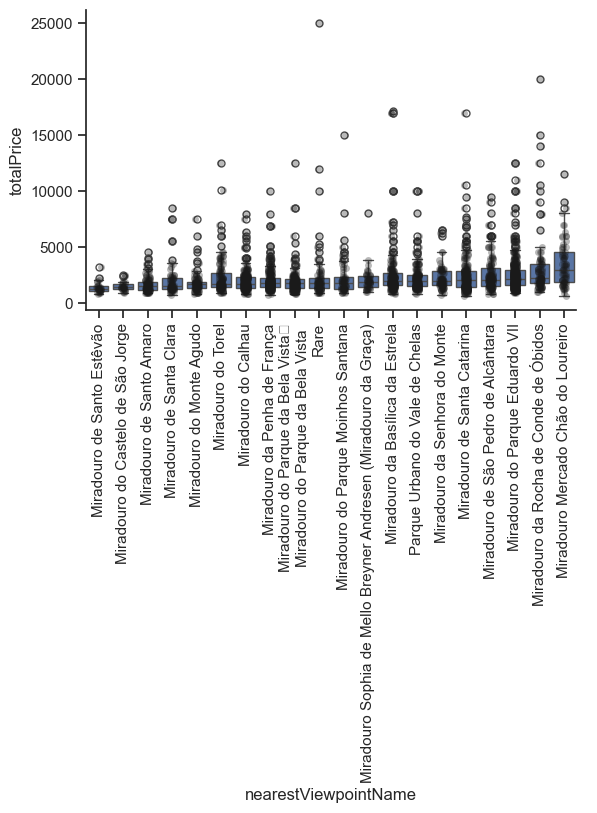

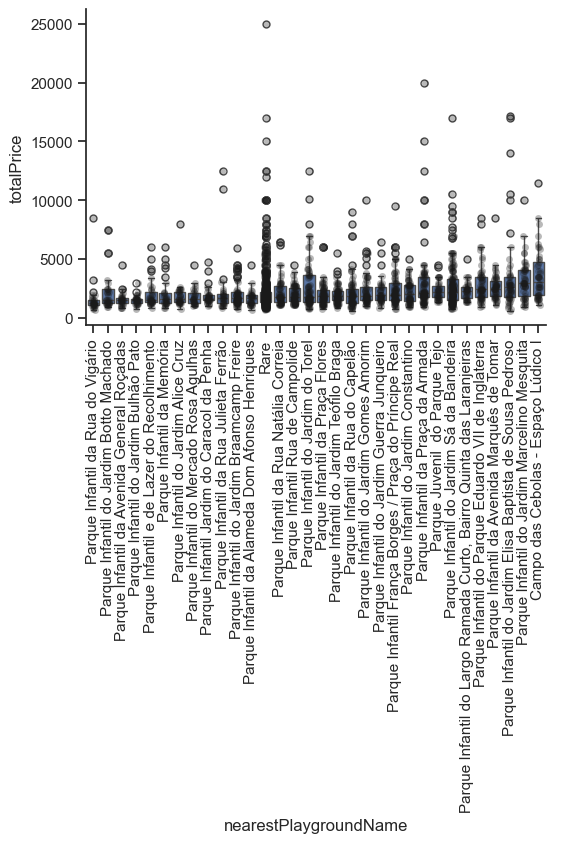

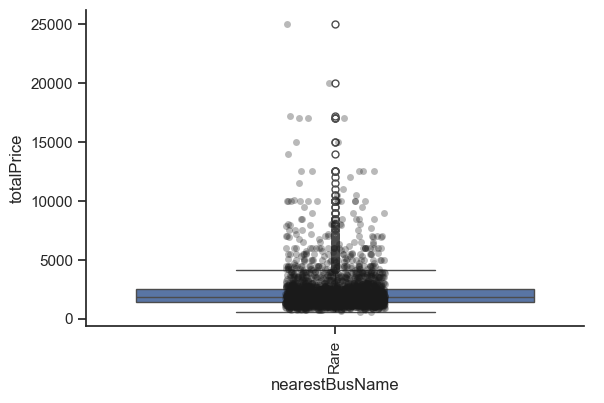

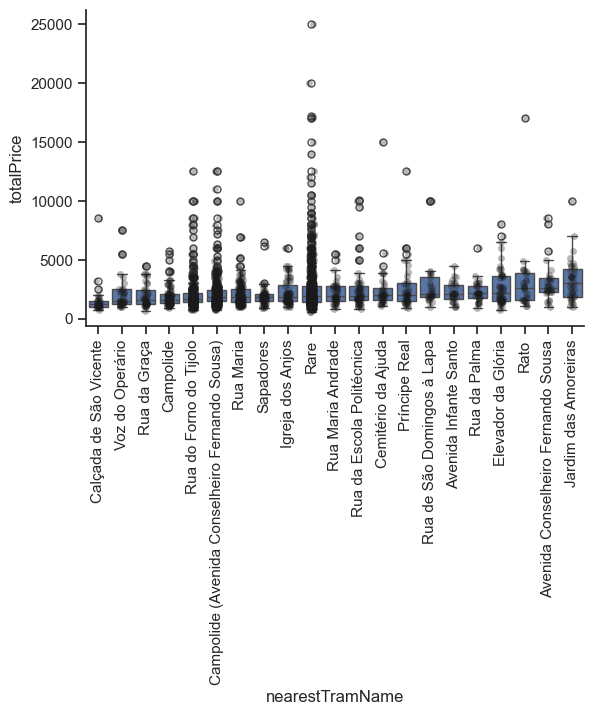

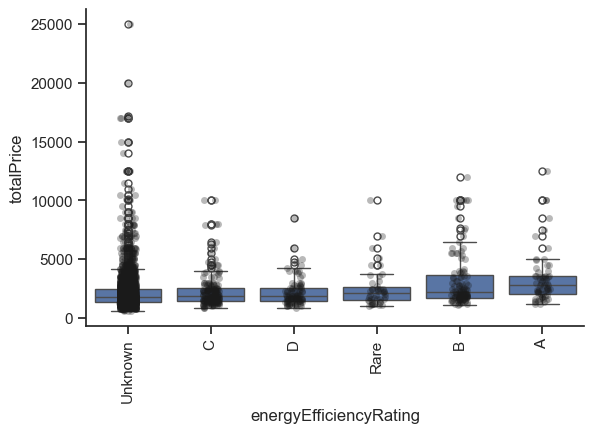

In [35]:
for var in cat_vars:
    order_idx = data_train.groupby(var)[target[0]].median().sort_values().index
    # make boxplot with Catplot
    sns.catplot(
        x=var, y=target[0], data=data_train, kind="box", height=4, aspect=1.5, order=order_idx
    )
    # add data points to boxplot with stripplot
    strip_plot = sns.stripplot(
        x=var, y=target[0], data=data_train, jitter=0.1, alpha=0.3, color="k", order=order_idx
    )
    # Set proper tick locations before changing labels
    strip_plot.set_xticks(range(len(data_train[var].unique())))
    strip_plot.set_xticklabels(strip_plot.get_xticklabels(), rotation=90)

    plt.show()

In [36]:
data_train.shape

(2730, 85)

In [37]:
len(features)

84

Clearly, the categories give information on the SalePrice, as different categories show different median sale prices.

In [38]:
from feature_engine.encoding import OrdinalEncoder

# set up the encoder
oe = OrdinalEncoder(encoding_method='ordered', variables=ordinal_vars)

# create the mappings
oe.fit(data_train[features], data_train[target].squeeze())
data_train[features] = oe.transform(data_train[features])

# mappings are stored and class can be saved
oe.encoder_dict_

{'district': {'Estrada de Benfica': 0,
  'Santa Engrácia': 1,
  'Pena': 2,
  'Telheiras': 3,
  'Castelo - Mouraria': 4,
  'São João de Brito': 5,
  'Alto de Santo Amaro': 6,
  'Alto do Lumiar - Quinta das Conchas - Quinta do Lambert': 7,
  'Centro': 8,
  'Laranjeiras': 9,
  'Bairro Alto': 10,
  'Campo de Santana - Santa Marta': 11,
  'Rare': 12,
  'Alfama - Sé': 13,
  'Doca de Alcântara': 14,
  'Graça': 15,
  'São Jorge de Arroios': 16,
  'Príncipe Real - São Bento': 17,
  'Expo Central': 18,
  'Praça de Espanha - Sete Rios': 19,
  'Anjos': 20,
  'Entrecampos': 21,
  'Campo Grande': 22,
  'Expo Norte': 23,
  'São Vicente de Fora': 24,
  'Gulbenkian - Praça Espanha': 25,
  'Santa Catarina': 26,
  'São Sebastião da Pedreira': 27,
  'Príncipe Real': 28,
  'Campo Pequeno': 29,
  'Bairro Azul - Parque Eduardo VII': 30,
  'Santos-o-Velho - Madragoa': 31,
  'Rato - Amoreiras': 32,
  'Chiado': 33,
  'Cais do Sodré - Santos': 34,
  'Lapa': 35,
  'Av. da Liberdade - Marquês de Pombal': 36,
  'Ba

In [39]:
data_train.shape

(2730, 85)

In [40]:
from feature_engine.encoding import OneHotEncoder

# set up the encoder
ohe = OneHotEncoder(drop_last=True, variables=one_hot_vars)

ohe.fit(data_train[features])
new_features = ohe.get_feature_names_out()
data_train[new_features] = ohe.transform(data_train[features])
data_train = data_train.drop(columns=one_hot_vars)
features = new_features

In [41]:
data_train

floor   size  rooms  bathrooms  municipality  district  \
propertyCode                                                           
33927611          1   75.0      2          1             8         0   
33818215          1   74.0      1          1             8        12   
33921433          2   11.0      1          1            14        12   
34009508          2   50.0      1          1            15        17   
27801065          2   96.0      4          2            19        12   
...             ...    ...    ...        ...           ...       ...   
33857958          5   95.0      1          2            11        15   
33873796          5  168.0      3          1            12        20   
33888919          2  150.0      4          2            19        13   
33934316          0   38.0      1          1            10         8   
33886688          6   70.0      1          1            22        31   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33927611      38.745753  -9.181090        False      True           False   
33818215      38.752713  -9.183459        False     False           False   
33921433      38.743373  -9.137448        False     False           False   
34009508      38.714855  -9.151628         True     False           False   
27801065      38.716699  -9.131327        False     False           False   
...                 ...        ...          ...       ...             ...   
33857958      38.720790  -9.125598        False      True           False   
33873796      38.725788  -9.132446        False     False           False   
33888919      38.709598  -9.130971         True     False           False   
33934316      38.727444  -9.165805         True     False           False   
33886688      38.708913  -9.156746        False     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33927611        False     True      False   False       False   
33818215         True    False      False   False       False   
33921433        False    False      False   False       False   
34009508        False     True      False   False       False   
27801065        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33857958        False    False      False   False       False   
33873796         True    False      False   False       False   
33888919        False    False      False   False       False   
33934316        False     True      False   False       False   
33886688        False    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33927611                  False    False                   False   
33818215                  False    False                   False   
33921433                  False    False                   False   
34009508                  False    False                   False   
27801065                  False    False                   False   
...                         ...      ...                     ...   
33857958                  False    False                   False   
33873796                  False    False                   False   
33888919                  False    False                   False   
33934316                  False    False                   False   
33886688                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33927611               False            False                          False   
33818215               False             True                           True   
33921433               F

# Numerical variables

Let's go ahead and find out what numerical variables we have in the dataset

In [42]:
print('Number of numerical variables: ', len(num_vars))

# visualise the numerical variables
data_train[num_vars].head()

Number of numerical variables:  16


size  rooms  bathrooms   latitude  longitude  \
propertyCode                                                 
33927611      75.0      2          1  38.745753  -9.181090   
33818215      74.0      1          1  38.752713  -9.183459   
33921433      11.0      1          1  38.743373  -9.137448   
34009508      50.0      1          1  38.714855  -9.151628   
27801065      96.0      4          2  38.716699  -9.131327   

              distanceToCityCenter  distanceToNearestMall  \
propertyCode                                                
33927611               7495.052831             818.702643   
33818215               8418.346385             659.820518   
33921433               5180.268320             174.002777   
34009508               2108.831662             464.767158   
27801065               1446.041414             458.594287   

              distanceToNearestTrain  distanceToNearestFair  \
propertyCode                                                  
33927611                 1770.408717            2189.616837   
33818215                 2153.578281            1171.722994   
33921433                  505.810977             322.511279   
34009508                 1076.115068             359.475106   
27801065                 1091.344877             205.762881   

              distanceToNearestPark  distanceToNearestMarket  \
propertyCode                                                   
33927611                 233.394504              1410.474856   
33818215                 740.641704               676.242845   
33921433                  31.301038               501.572125   
34009508                  29.149172              1331.197477   
27801065                  48.000572              2142.156872   

              distanceToNearestMetro  distanceToNearestViewpoint  \
propertyCode                                                       
33927611                  609.050851                 1292.553647   
33818215                  546.619363                 2316.599158   
33921433                  463.723883                 1932.990573   
34009508                  829.685090                  820.700980   
27801065                  511.465305                   48.197338   

              distanceToNearestPlayground  distanceToNearestBus  \
propertyCode                                                      
33927611                        66.730337             73.780263   
33818215                       528.858356            242.547439   
33921433                       116.499187            182.650279   
34009508                        42.222276              5.001742   
27801065                       196.728478            122.272419   

              distanceToNearestTram  
propertyCode                         
33927611                3420.166048  
33818215                4375.470809  
33921433                2830.544002  
34009508                 393.788365  
27801065                 189.384462

## Discrete variables

Let's go ahead and find which variables are discrete, i.e., show a finite number of values

In [43]:
#  let's male a list of discrete variables
discrete_vars = [var for var in num_vars if len(data_train[var].unique()) < 20]


print("Number of discrete variables: ", len(discrete_vars))

Number of discrete variables:  2


In [44]:
# let's visualise the discrete variables

data_train[discrete_vars].head()

rooms  bathrooms
propertyCode                  
33927611          2          1
33818215          1          1
33921433          1          1
34009508          1          1
27801065          4          2

These discrete variables refer to the number of rooms and bathrooms.

We expect higher prices, with bigger numbers.

Let's go ahead and analyse their contribution to the listing price.

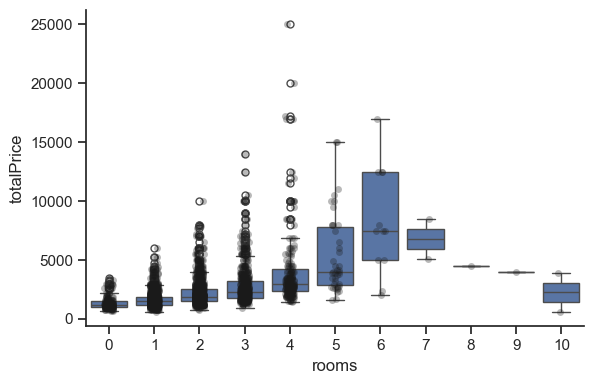

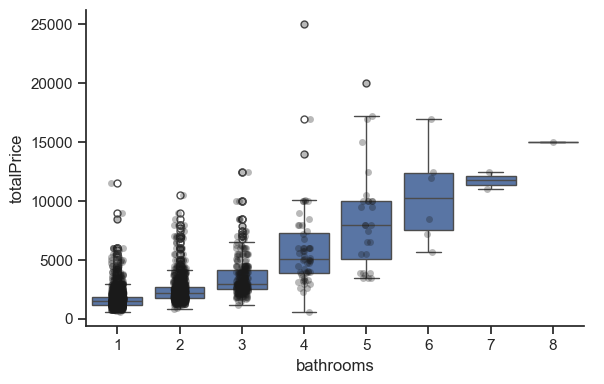

In [45]:
for var in discrete_vars:
    # make boxplot with Catplot
    sns.catplot(x=var, y=target[0], data=data_train, kind="box", height=4, aspect=1.5)
    # add data points to boxplot with stripplot
    sns.stripplot(x=var, y=target[0], data=data_train, jitter=0.1, alpha=0.3, color='k')
    plt.show()

Clearly, the price does increase with increasing number of rooms and bathrooms. There seem to be few outliers in both variables, so we'll have to deal with those in a bit.

## Continuous variables

Let's go ahead and find the distribution of the continuous variables. We will consider continuous variables to all those that are not temporal or discrete.

In [46]:
# make list of continuous variables
cont_vars = [var for var in num_vars if var not in discrete_vars]

print("Number of continuous variables: ", len(cont_vars))

Number of continuous variables:  14


In [47]:
# let's visualise the continuous variables

data_train[cont_vars].head()

size   latitude  longitude  distanceToCityCenter  \
propertyCode                                                     
33927611      75.0  38.745753  -9.181090           7495.052831   
33818215      74.0  38.752713  -9.183459           8418.346385   
33921433      11.0  38.743373  -9.137448           5180.268320   
34009508      50.0  38.714855  -9.151628           2108.831662   
27801065      96.0  38.716699  -9.131327           1446.041414   

              distanceToNearestMall  distanceToNearestTrain  \
propertyCode                                                  
33927611                 818.702643             1770.408717   
33818215                 659.820518             2153.578281   
33921433                 174.002777              505.810977   
34009508                 464.767158             1076.115068   
27801065                 458.594287             1091.344877   

              distanceToNearestFair  distanceToNearestPark  \
propertyCode                                                 
33927611                2189.616837             233.394504   
33818215                1171.722994             740.641704   
33921433                 322.511279              31.301038   
34009508                 359.475106              29.149172   
27801065                 205.762881              48.000572   

              distanceToNearestMarket  distanceToNearestMetro  \
propertyCode                                                    
33927611                  1410.474856              609.050851   
33818215                   676.242845              546.619363   
33921433                   501.572125              463.723883   
34009508                  1331.197477              829.685090   
27801065                  2142.156872              511.465305   

              distanceToNearestViewpoint  distanceToNearestPlayground  \
propertyCode                                                            
33927611                     1292.553647                    66.730337   
33818215                     2316.599158                   528.858356   
33921433                     1932.990573                   116.499187   
34009508                      820.700980                    42.222276   
27801065                       48.197338                   196.728478   

              distanceToNearestBus  distanceToNearestTram  
propertyCode                                               
33927611                 73.780263            3420.166048  
33818215                242.547439            4375.470809  
33921433                182.650279            2830.544002  
34009508                  5.001742             393.788365  
27801065                122.272419             189.384462

In [48]:
data_train[cont_vars].describe()

size     latitude    longitude  distanceToCityCenter  \
count   2730.000000  2730.000000  2730.000000           2730.000000   
mean     122.247253    38.729115    -9.149990           4504.371623   
std     1540.277996     0.020488     0.024408           2847.676958   
min       11.000000    38.693598    -9.226113            188.514382   
25%       53.250000    38.712760    -9.164176           2133.516930   
50%       80.000000    38.724361    -9.147836           3837.003520   
75%      120.000000    38.742999    -9.133896           6320.141398   
max    80500.000000    38.793670    -9.091136          13008.927352   

       distanceToNearestMall  distanceToNearestTrain  distanceToNearestFair  \
count            2730.000000             2730.000000            2730.000000   
mean              759.881094             1273.266692            1227.971959   
std               600.374370              893.854869             870.396990   
min                 1.846369               21.415188               7.834411   
25%               324.236050              698.782152             525.361783   
50%               573.750694             1072.283259            1039.393952   
75%              1003.936649             1613.901350            1753.150782   
max              3686.974267             7067.260209            5509.990808   

       distanceToNearestPark  distanceToNearestMarket  distanceToNearestMetro  \
count            2730.000000              2730.000000             2730.000000   
mean              406.461733              1468.817373             1081.447341   
std               227.324560              1025.966729             1357.446433   
min                 1.815796                21.926069               11.315896   
25%               241.209884               762.339896              382.660364   
50%               378.415401              1271.378179              636.705737   
75%               533.102700              1900.191196             1110.818716   
max              1692.846769              7132.436102             8146.904727   

       distanceToNearestViewpoint  distanceToNearestPlayground  \
count                 2730.000000                  2730.000000   
mean                  1263.258833                   398.352680   
std                   1154.601157                   230.360832   
min                      6.535194                     6.428992   
25%                    449.685977                   220.496343   
50%                    869.658960                   365.695838   
75%                   1602.512419                   534.679696   
max                   6235.514649                  1856.025882   

       distanceToNearestBus  distanceToNearestTram  
count           2730.000000            2730.000000  
mean             142.637373            1815.286165  
std               76.832703            2258.863501  
min                0.844090               4.286981  
25%               87.007091             220.360034  
50%              130.951865             605.663619  
75%              185.719897            2772.426474  
max              559.181861           10621.862955

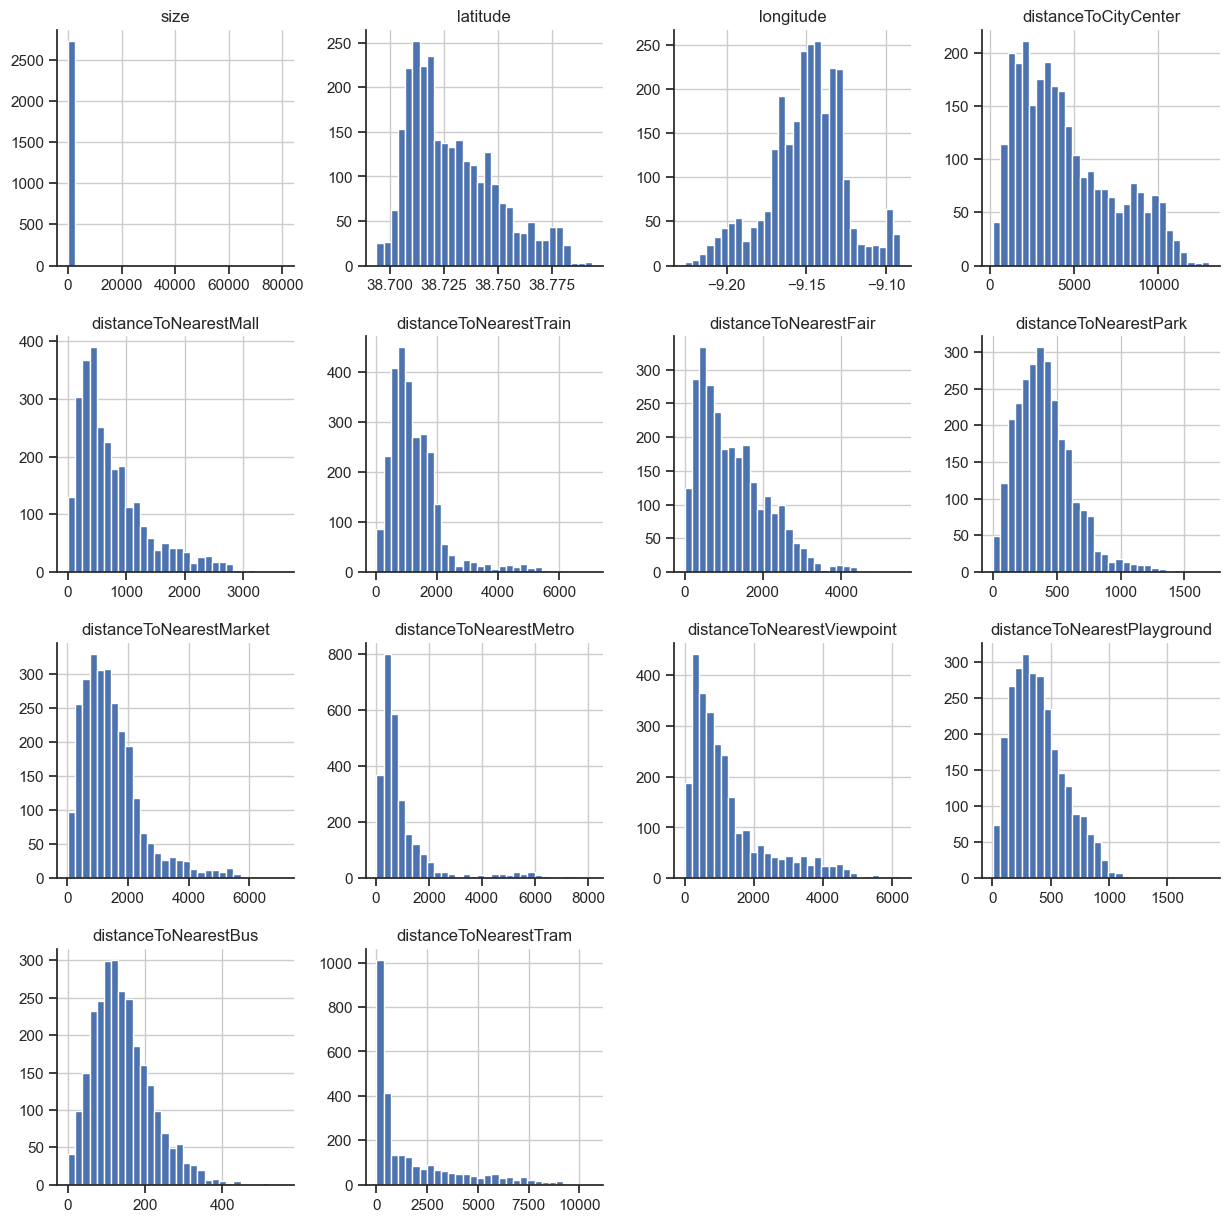

In [49]:
# lets plot histograms for all continuous variables

data_train[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

The variables are not normally distributed, and most of them are left skewed.

Sometimes, transforming the variables to improve the value spread, improves the model performance. But it is unlikely that a transformation will help change the distribution of the super skewed variables dramatically.

We can apply a Yeo-Johnson transformation, let's go ahead and do that.

In [50]:
# Identify columns with non-finite values
for var in cont_vars:
    if not np.all(np.isfinite(data_train[var])):
        print(f"Non-finite values found in column: {var}")

### Yeo-Johnson transformation

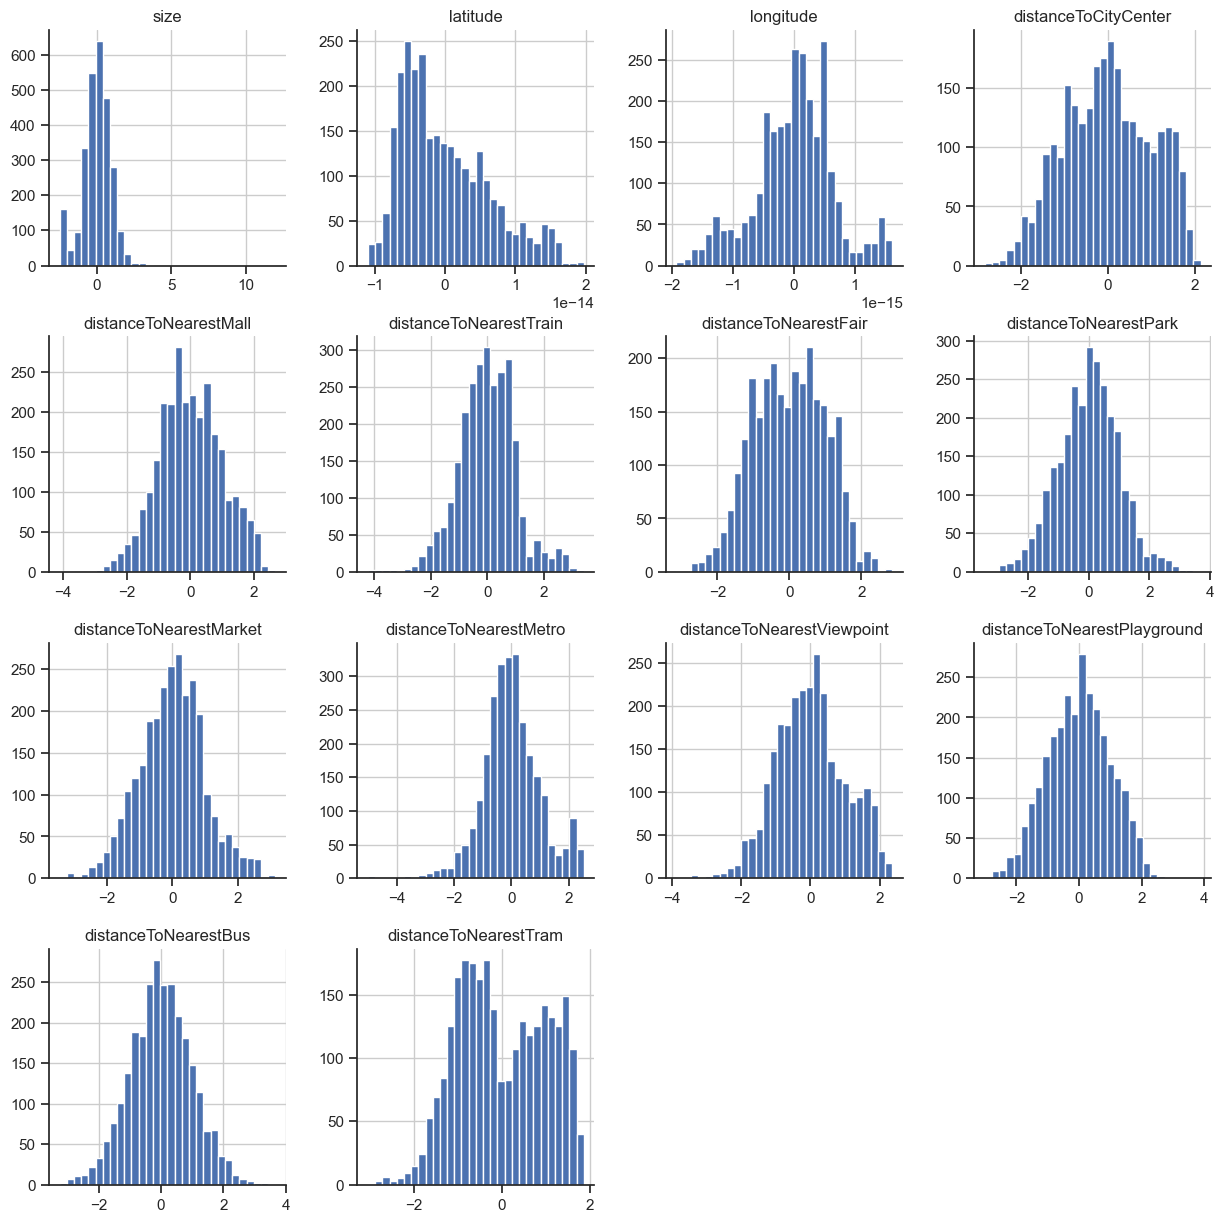

In [51]:
# Let's go ahead and analyse the distributions of the variables
# after applying a yeo-johnson transformation

# temporary copy of the data
tmp = data_train.copy()

for var in cont_vars + ["totalPrice"]:
    # Apply PowerTransformer
    pt = PowerTransformer()
    tmp[var] = pt.fit_transform(data_train[var].values.reshape(-1,1))

    
# plot the histograms of the transformed variables
tmp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

For latitude and longitude, the transformation didn't do anything useful, as the values are too small.

For the others, the values seem to be spread more evenly in the range and more normally distributed. Whether this helps improve the predictive power, remains to be seen. To determine if this is the case, we should train a model with the original values and one with the transformed values, and determine model performance, and feature importance.

In [52]:
yeo_johnson_vars = [var for var in cont_vars if var == 'size' or 'distance' in var]

In [53]:
yeo_johnson_vars

['size',
 'distanceToCityCenter',
 'distanceToNearestMall',
 'distanceToNearestTrain',
 'distanceToNearestFair',
 'distanceToNearestPark',
 'distanceToNearestMarket',
 'distanceToNearestMetro',
 'distanceToNearestViewpoint',
 'distanceToNearestPlayground',
 'distanceToNearestBus',
 'distanceToNearestTram']

# Outliers

We're interested in removing the outliers for a few key features: size, rooms, and bathrooms. Additionally, we recognized that there are few re-ocurring values in the size feature that are likely data entry errors and/or data inconsistencies.

We have different strategies for each of them, so we'll tackle those in a bit. First, we'll tacke the overly frequent values in the size feature.

In [54]:
# Identify overly frequent values dynamically
def flag_frequent_values(df, column, threshold=0.05):
    """
    Identifies values in a column that appear with a frequency higher than `threshold` (default: 5% of the data).
    Returns a list of those values.
    """
    value_counts = df[column].value_counts(normalize=True)
    frequent_values = value_counts[value_counts > threshold].index.tolist()
    return frequent_values

In [55]:
from sklearn.impute import KNNImputer, MissingIndicator

# Find overly common values in the 'size' column
frequent_sizes = flag_frequent_values(data_train, 'size', threshold=0.04)

# Replace overly common values with NaN
data_train.loc[data_train['size'].isin(frequent_sizes), 'size'] = np.nan

# Apply Missing Indicator
missing_indicator = MissingIndicator()
missing_indicator.fit(data_train[features])
new_features = missing_indicator.get_feature_names_out().tolist()
data_train[new_features] = missing_indicator.transform(data_train[features])
features.extend(new_features)

In [56]:
frequent_sizes

[11.0, 50.0]

In [57]:
data_train

floor   size  rooms  bathrooms  municipality  district  \
propertyCode                                                           
33927611          1   75.0      2          1             8         0   
33818215          1   74.0      1          1             8        12   
33921433          2    NaN      1          1            14        12   
34009508          2    NaN      1          1            15        17   
27801065          2   96.0      4          2            19        12   
...             ...    ...    ...        ...           ...       ...   
33857958          5   95.0      1          2            11        15   
33873796          5  168.0      3          1            12        20   
33888919          2  150.0      4          2            19        13   
33934316          0   38.0      1          1            10         8   
33886688          6   70.0      1          1            22        31   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33927611      38.745753  -9.181090        False      True           False   
33818215      38.752713  -9.183459        False     False           False   
33921433      38.743373  -9.137448        False     False           False   
34009508      38.714855  -9.151628         True     False           False   
27801065      38.716699  -9.131327        False     False           False   
...                 ...        ...          ...       ...             ...   
33857958      38.720790  -9.125598        False      True           False   
33873796      38.725788  -9.132446        False     False           False   
33888919      38.709598  -9.130971         True     False           False   
33934316      38.727444  -9.165805         True     False           False   
33886688      38.708913  -9.156746        False     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33927611        False     True      False   False       False   
33818215         True    False      False   False       False   
33921433        False    False      False   False       False   
34009508        False     True      False   False       False   
27801065        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33857958        False    False      False   False       False   
33873796         True    False      False   False       False   
33888919        False    False      False   False       False   
33934316        False     True      False   False       False   
33886688        False    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33927611                  False    False                   False   
33818215                  False    False                   False   
33921433                  False    False                   False   
34009508                  False    False                   False   
27801065                  False    False                   False   
...                         ...      ...                     ...   
33857958                  False    False                   False   
33873796                  False    False                   False   
33888919                  False    False                   False   
33934316                  False    False                   False   
33886688                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33927611               False            False                          False   
33818215               False             True                           True   
33921433               F

In [58]:
len(features)

87

In [59]:
# Apply KNN Imputer
size_imputer = KNNImputer(n_neighbors=5, weights='distance')
size_imputer.fit(data_train[num_vars])
new_features = size_imputer.get_feature_names_out().tolist()
data_train[new_features] = size_imputer.transform(data_train[num_vars])

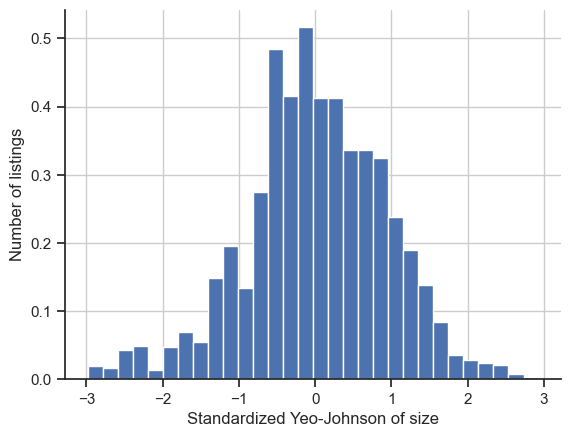

In [60]:
# Transform with the Yeo-Johnson transformation
pt_features = PowerTransformer()
data_train[yeo_johnson_vars] = pt_features.fit_transform(data_train[yeo_johnson_vars])

pt_target = PowerTransformer()
data_train[target] = pt_target.fit_transform(data_train[target])

# Filter out extreme values
data_train = data_train[abs(data_train['size']) <= 3]
data_train = data_train[abs(data_train[target[0]]) <= 3]

# Plot
data_train['size'].hist(bins=30, density=True)
plt.ylabel('Number of listings')
plt.xlabel('Standardized Yeo-Johnson of size')
plt.show()

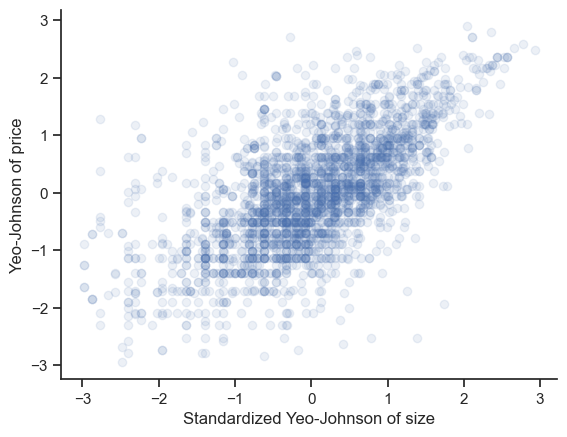

In [61]:
# Plot
plt.scatter(x='size', y='totalPrice', data=data_train, alpha=0.1)
plt.ylabel('Yeo-Johnson of price')
plt.xlabel('Standardized Yeo-Johnson of size')
plt.show()

In [62]:
data_train

floor      size  rooms  bathrooms  municipality  district  \
propertyCode                                                              
33927611          1 -0.203210    2.0        1.0             8         0   
33818215          1 -0.227758    1.0        1.0             8        12   
33921433          2  0.585232    1.0        1.0            14        12   
34009508          2 -0.030017    1.0        1.0            15        17   
27801065          2  0.242420    4.0        2.0            19        12   
...             ...       ...    ...        ...           ...       ...   
33857958          5  0.223743    1.0        2.0            11        15   
33873796          5  1.211546    3.0        1.0            12        20   
33888919          2  1.019879    4.0        2.0            19        13   
33934316          0 -1.486902    1.0        1.0            10         8   
33886688          6 -0.329733    1.0        1.0            22        31   

               latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                                
33927611      38.745753  -9.181090        False      True           False   
33818215      38.752713  -9.183459        False     False           False   
33921433      38.743373  -9.137448        False     False           False   
34009508      38.714855  -9.151628         True     False           False   
27801065      38.716699  -9.131327        False     False           False   
...                 ...        ...          ...       ...             ...   
33857958      38.720790  -9.125598        False      True           False   
33873796      38.725788  -9.132446        False     False           False   
33888919      38.709598  -9.130971         True     False           False   
33934316      38.727444  -9.165805         True     False           False   
33886688      38.708913  -9.156746        False     False           False   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33927611        False     True      False   False       False   
33818215         True    False      False   False       False   
33921433        False    False      False   False       False   
34009508        False     True      False   False       False   
27801065        False    False      False   False       False   
...               ...      ...        ...     ...         ...   
33857958        False    False      False   False       False   
33873796         True    False      False   False       False   
33888919        False    False      False   False       False   
33934316        False     True      False   False       False   
33886688        False    False      False   False       False   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33927611                  False    False                   False   
33818215                  False    False                   False   
33921433                  False    False                   False   
34009508                  False    False                   False   
27801065                  False    False                   False   
...                         ...      ...                     ...   
33857958                  False    False                   False   
33873796                  False    False                   False   
33888919                  False    False                   False   
33934316                  False    False                   False   
33886688                  False    False                   False   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33927611               False            False                          False   
33818215               False             True                    

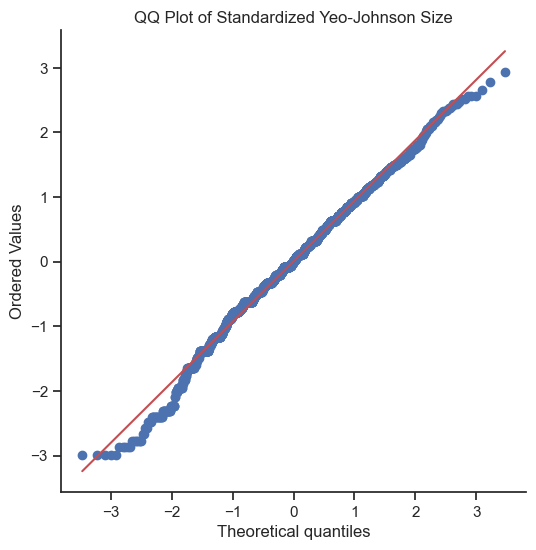

In [63]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
stats.probplot(data_train["size"], dist="norm", plot=ax)
ax.set_title("QQ Plot of Standardized Yeo-Johnson Size")
plt.show()

In [64]:
data_train['size'].describe()

count    2702.000000
mean        0.008648
std         0.937513
min        -2.984135
25%        -0.584673
50%         0.019586
75%         0.635682
max         2.928171
Name: size, dtype: float64

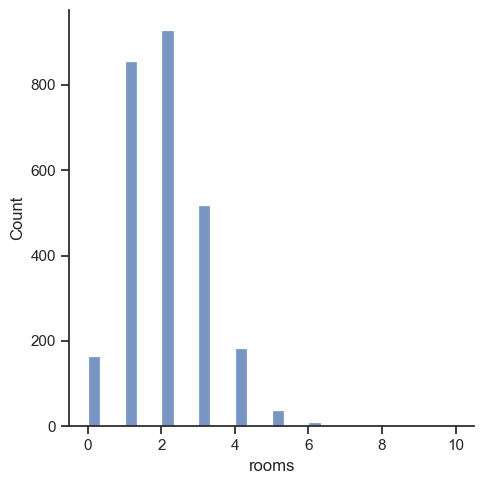

In [65]:
sns.displot(data_train, x='rooms', kind='hist', bins=30)
plt.show()


In [66]:
data_train['rooms'].describe()

count    2702.000000
mean        1.956699
std         1.128857
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        10.000000
Name: rooms, dtype: float64

In [67]:
def remove_outliers_iqr(df, column, threshold=1.5):
    """
    Removes outliers from a DataFrame column using the IQR method.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        column (str): The name of the column to check for outliers.
        threshold (float, optional): The IQR multiplier (default is 1.5).

    Returns:
        pd.DataFrame: A new DataFrame with outliers removed.
    """
    Q1 = df[column].quantile(0.25)  # First quartile (25th percentile)
    Q3 = df[column].quantile(0.75)  # Third quartile (75th percentile)
    IQR = Q3 - Q1  # Interquartile range

    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_filtered = df.copy()

    df_filtered = df_filtered[(df_filtered[column] >= lower_bound) & (df_filtered[column] <= upper_bound)]
    
    return df_filtered

In [68]:
data_train = remove_outliers_iqr(data_train, 'rooms')

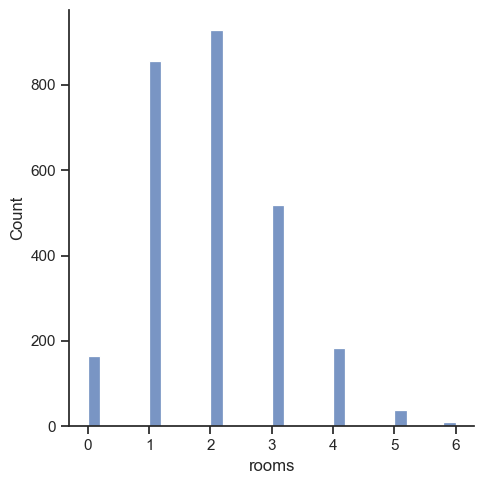

In [69]:
sns.displot(data_train, x='rooms', kind='hist', bins=30)
plt.show()

In [70]:
data_train['rooms'].describe()

count    2697.000000
mean        1.945124
std         1.096237
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

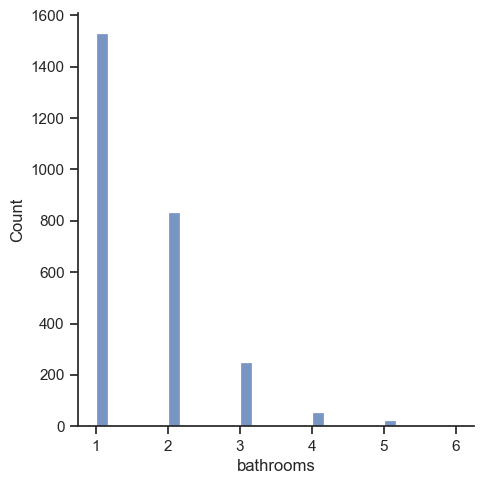

In [71]:
sns.displot(data_train, x='bathrooms', kind='hist', bins=30)
plt.show()

In [72]:
data_train['bathrooms'].describe()

count    2697.000000
mean        1.597330
std         0.825839
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: bathrooms, dtype: float64

In [73]:
# Count occurrences of each value
value_counts = data_train['bathrooms'].value_counts(normalize=True)

# Define a threshold (e.g., values appearing in less than 1% of listings are outliers)
threshold = 0.01
outlier_values = value_counts[value_counts < threshold].index

# Remove or flag outliers
data_train = data_train[~data_train['bathrooms'].isin(outlier_values)]

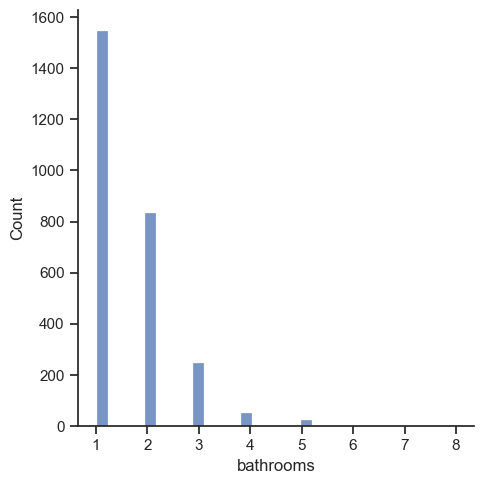

In [74]:
sns.displot(tmp, x='bathrooms', kind='hist', bins=30)
plt.show()

In [75]:
data_train['bathrooms'].describe()

count    2669.000000
mean        1.560135
std         0.744696
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: bathrooms, dtype: float64

# Data Preparation

In [76]:
boolean_vars = data_train.select_dtypes(include='bool').columns.tolist()
binary_vars = [var for var in data_train.columns if data_train[var].nunique() == 2 or var in boolean_vars]
non_binary_vars = [var for var in data_train.columns if var not in binary_vars and var not in target]

In [77]:
binary_vars

['showAddress',
 'hasVideo',
 'newDevelopment',
 'hasLift',
 'hasPlan',
 'has3DTour',
 'has360',
 'hasStaging',
 'topNewDevelopment',
 'topPlus',
 'newDevelopmentFinished',
 'isPriceLowered',
 'hasParkingSpace',
 'isParkingSpaceIncludedInPrice',
 'hasSwimmingPool',
 'hasBalcony',
 'hasGarage',
 'hasParking',
 'hasAirConditioning',
 'hasClotheslineSpace',
 'hasBuiltInWardrobes',
 'hasDishwasher',
 'hasWashingMachine',
 'hasDryer',
 'hasLift.1',
 'isFurnished',
 'isPetFriendly',
 'isSmokingAllowed',
 'isWheelchairAccessible',
 'hasGarden',
 'hasFireplace',
 'hasAlarmSystem',
 'hasCityViews',
 'hasWaterViews',
 'isLuxury',
 'isTemporaryContract',
 'isLongTermContract',
 'isStudentFriendly',
 'hasHomeAppliances',
 'hasOven',
 'hasMicrowave',
 'hasRefrigerator',
 'hasStove',
 'hasTerrace',
 'hasStorageRoom',
 'hasInternetIncluded',
 'hasCableTVIncluded',
 'hasSmartHomeFeatures',
 'hasCCTV',
 'hasGym',
 'isNewlyRenovated',
 'hasModernFinish',
 'propertyType_flat',
 'propertyType_Rare',
 'pro

In [78]:
non_binary_vars

['floor',
 'size',
 'rooms',
 'bathrooms',
 'municipality',
 'district',
 'latitude',
 'longitude',
 'distanceToCityCenter',
 'distanceToNearestMall',
 'nearestMallName',
 'distanceToNearestTrain',
 'nearestTrainName',
 'distanceToNearestFair',
 'nearestFairName',
 'distanceToNearestPark',
 'nearestParkName',
 'distanceToNearestMarket',
 'nearestMarketName',
 'distanceToNearestMetro',
 'nearestMetroName',
 'distanceToNearestViewpoint',
 'nearestViewpointName',
 'distanceToNearestPlayground',
 'nearestPlaygroundName',
 'distanceToNearestBus',
 'distanceToNearestTram',
 'nearestTramName',
 'energyEfficiencyRating']

In [79]:
data_train = data_train.astype(float)

In [80]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2669 entries, 33927611 to 33886688
Data columns (total 88 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   floor                          2669 non-null   float64
 1   size                           2669 non-null   float64
 2   rooms                          2669 non-null   float64
 3   bathrooms                      2669 non-null   float64
 4   municipality                   2669 non-null   float64
 5   district                       2669 non-null   float64
 6   latitude                       2669 non-null   float64
 7   longitude                      2669 non-null   float64
 8   showAddress                    2669 non-null   float64
 9   hasVideo                       2669 non-null   float64
 10  newDevelopment                 2669 non-null   float64
 11  hasLift                        2669 non-null   float64
 12  hasPlan                        2669 non-nu

In [81]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(data_train[non_binary_vars])
data_train[non_binary_vars] = ss.transform(data_train[non_binary_vars])

In [82]:
data_train

floor      size     rooms  bathrooms  municipality  district  \
propertyCode                                                                    
33927611     -0.970191 -0.206278  0.074896  -0.752307     -0.817551 -1.645672   
33818215     -0.970191 -0.233033 -0.859209  -0.752307     -0.817551 -0.422928   
33921433     -0.586286  0.653025 -0.859209  -0.752307      0.126307 -0.422928   
34009508     -0.586286 -0.017519 -0.859209  -0.752307      0.283617  0.086548   
27801065     -0.586286  0.279403  1.943107   0.590775      0.912856 -0.422928   
...                ...       ...       ...        ...           ...       ...   
33857958      0.565429  0.259047 -0.859209   0.590775     -0.345622 -0.117243   
33873796      0.565429  1.335630  1.009002  -0.752307     -0.188312  0.392234   
33888919     -0.586286  1.126736  1.943107   0.590775      0.912856 -0.321033   
33934316     -1.354096 -1.605342 -0.859209  -0.752307     -0.502931 -0.830510   
33886688      0.949334 -0.344172 -0.859209  -0.752307      1.384785  1.513082   

              latitude  longitude  showAddress  hasVideo  newDevelopment  \
propertyCode                                                               
33927611      0.810283  -1.274814          0.0       1.0             0.0   
33818215      1.149660  -1.372090          0.0       0.0             0.0   
33921433      0.694244   0.517435          0.0       0.0             0.0   
34009508     -0.696174  -0.064890          1.0       0.0             0.0   
27801065     -0.606277   0.768811          0.0       0.0             0.0   
...                ...        ...          ...       ...             ...   
33857958     -0.406830   1.004076          0.0       1.0             0.0   
33873796     -0.163147   0.722844          0.0       0.0             0.0   
33888919     -0.952494   0.783418          1.0       0.0             0.0   
33934316     -0.082402  -0.647107          1.0       0.0             0.0   
33886688     -0.985873  -0.275084          0.0       0.0             0.0   

              hasLift  hasPlan  has3DTour  has360  hasStaging  \
propertyCode                                                    
33927611          0.0      1.0        0.0     0.0         0.0   
33818215          1.0      0.0        0.0     0.0         0.0   
33921433          0.0      0.0        0.0     0.0         0.0   
34009508          0.0      1.0        0.0     0.0         0.0   
27801065          0.0      0.0        0.0     0.0         0.0   
...               ...      ...        ...     ...         ...   
33857958          0.0      0.0        0.0     0.0         0.0   
33873796          1.0      0.0        0.0     0.0         0.0   
33888919          0.0      0.0        0.0     0.0         0.0   
33934316          0.0      1.0        0.0     0.0         0.0   
33886688          0.0      0.0        0.0     0.0         0.0   

              topNewDevelopment  topPlus  newDevelopmentFinished  \
propertyCode                                                       
33927611                    0.0      0.0                     0.0   
33818215                    0.0      0.0                     0.0   
33921433                    0.0      0.0                     0.0   
34009508                    0.0      0.0                     0.0   
27801065                    0.0      0.0                     0.0   
...                         ...      ...                     ...   
33857958                    0.0      0.0                     0.0   
33873796                    0.0      0.0                     0.0   
33888919                    0.0      0.0                     0.0   
33934316                    0.0      0.0                     0.0   
33886688                    0.0      0.0                     0.0   

              isPriceLowered  hasParkingSpace  isParkingSpaceIncludedInPrice  \
propertyCode                                                                   
33927611                 0.0              0.0                            0.0   
338

**Disclaimer:**

There is certainly more that can be done to understand the nature of this data and the relationship of these variables with the target, SalePrice. And also about the distribution of the variables themselves.

However, we hope that through this notebook we gave you a flavour of what data analysis looks like.

# Exploratory Data Analysis

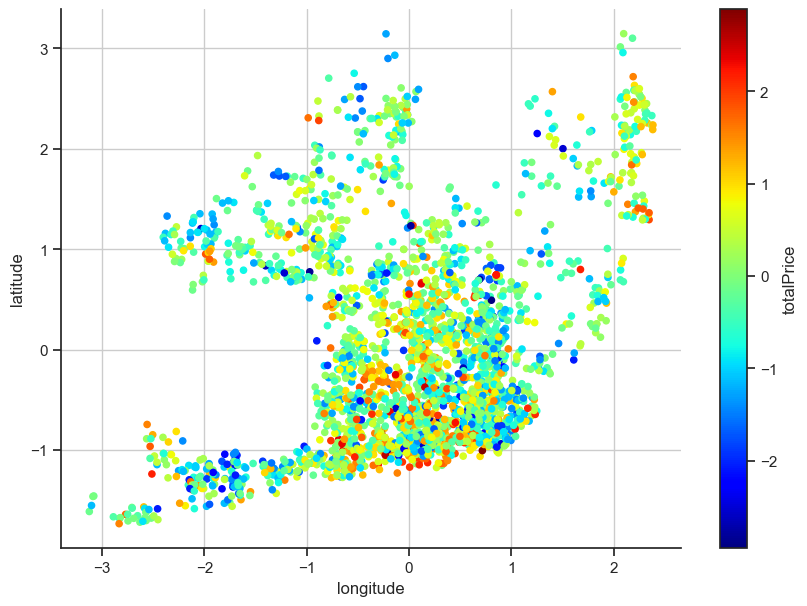

In [83]:
data_train.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    grid=True,
    c="totalPrice",
    cmap="jet",
    colorbar=True,
    legend=True,
    sharex=False,
    figsize=(10, 7),
)
plt.show()

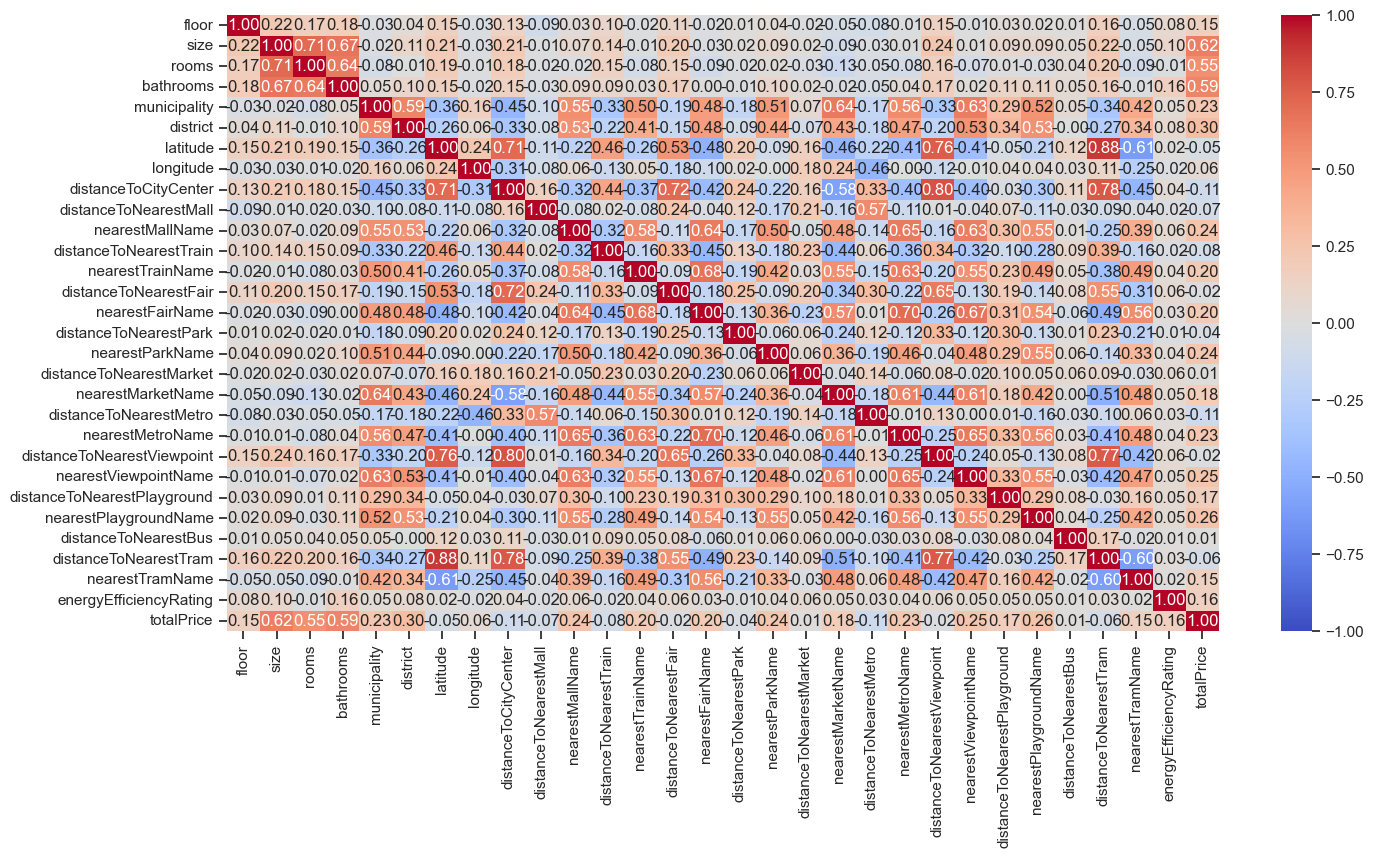

In [84]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    data_train[non_binary_vars + target].corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmax=1,
    vmin=-1,
)
plt.show()

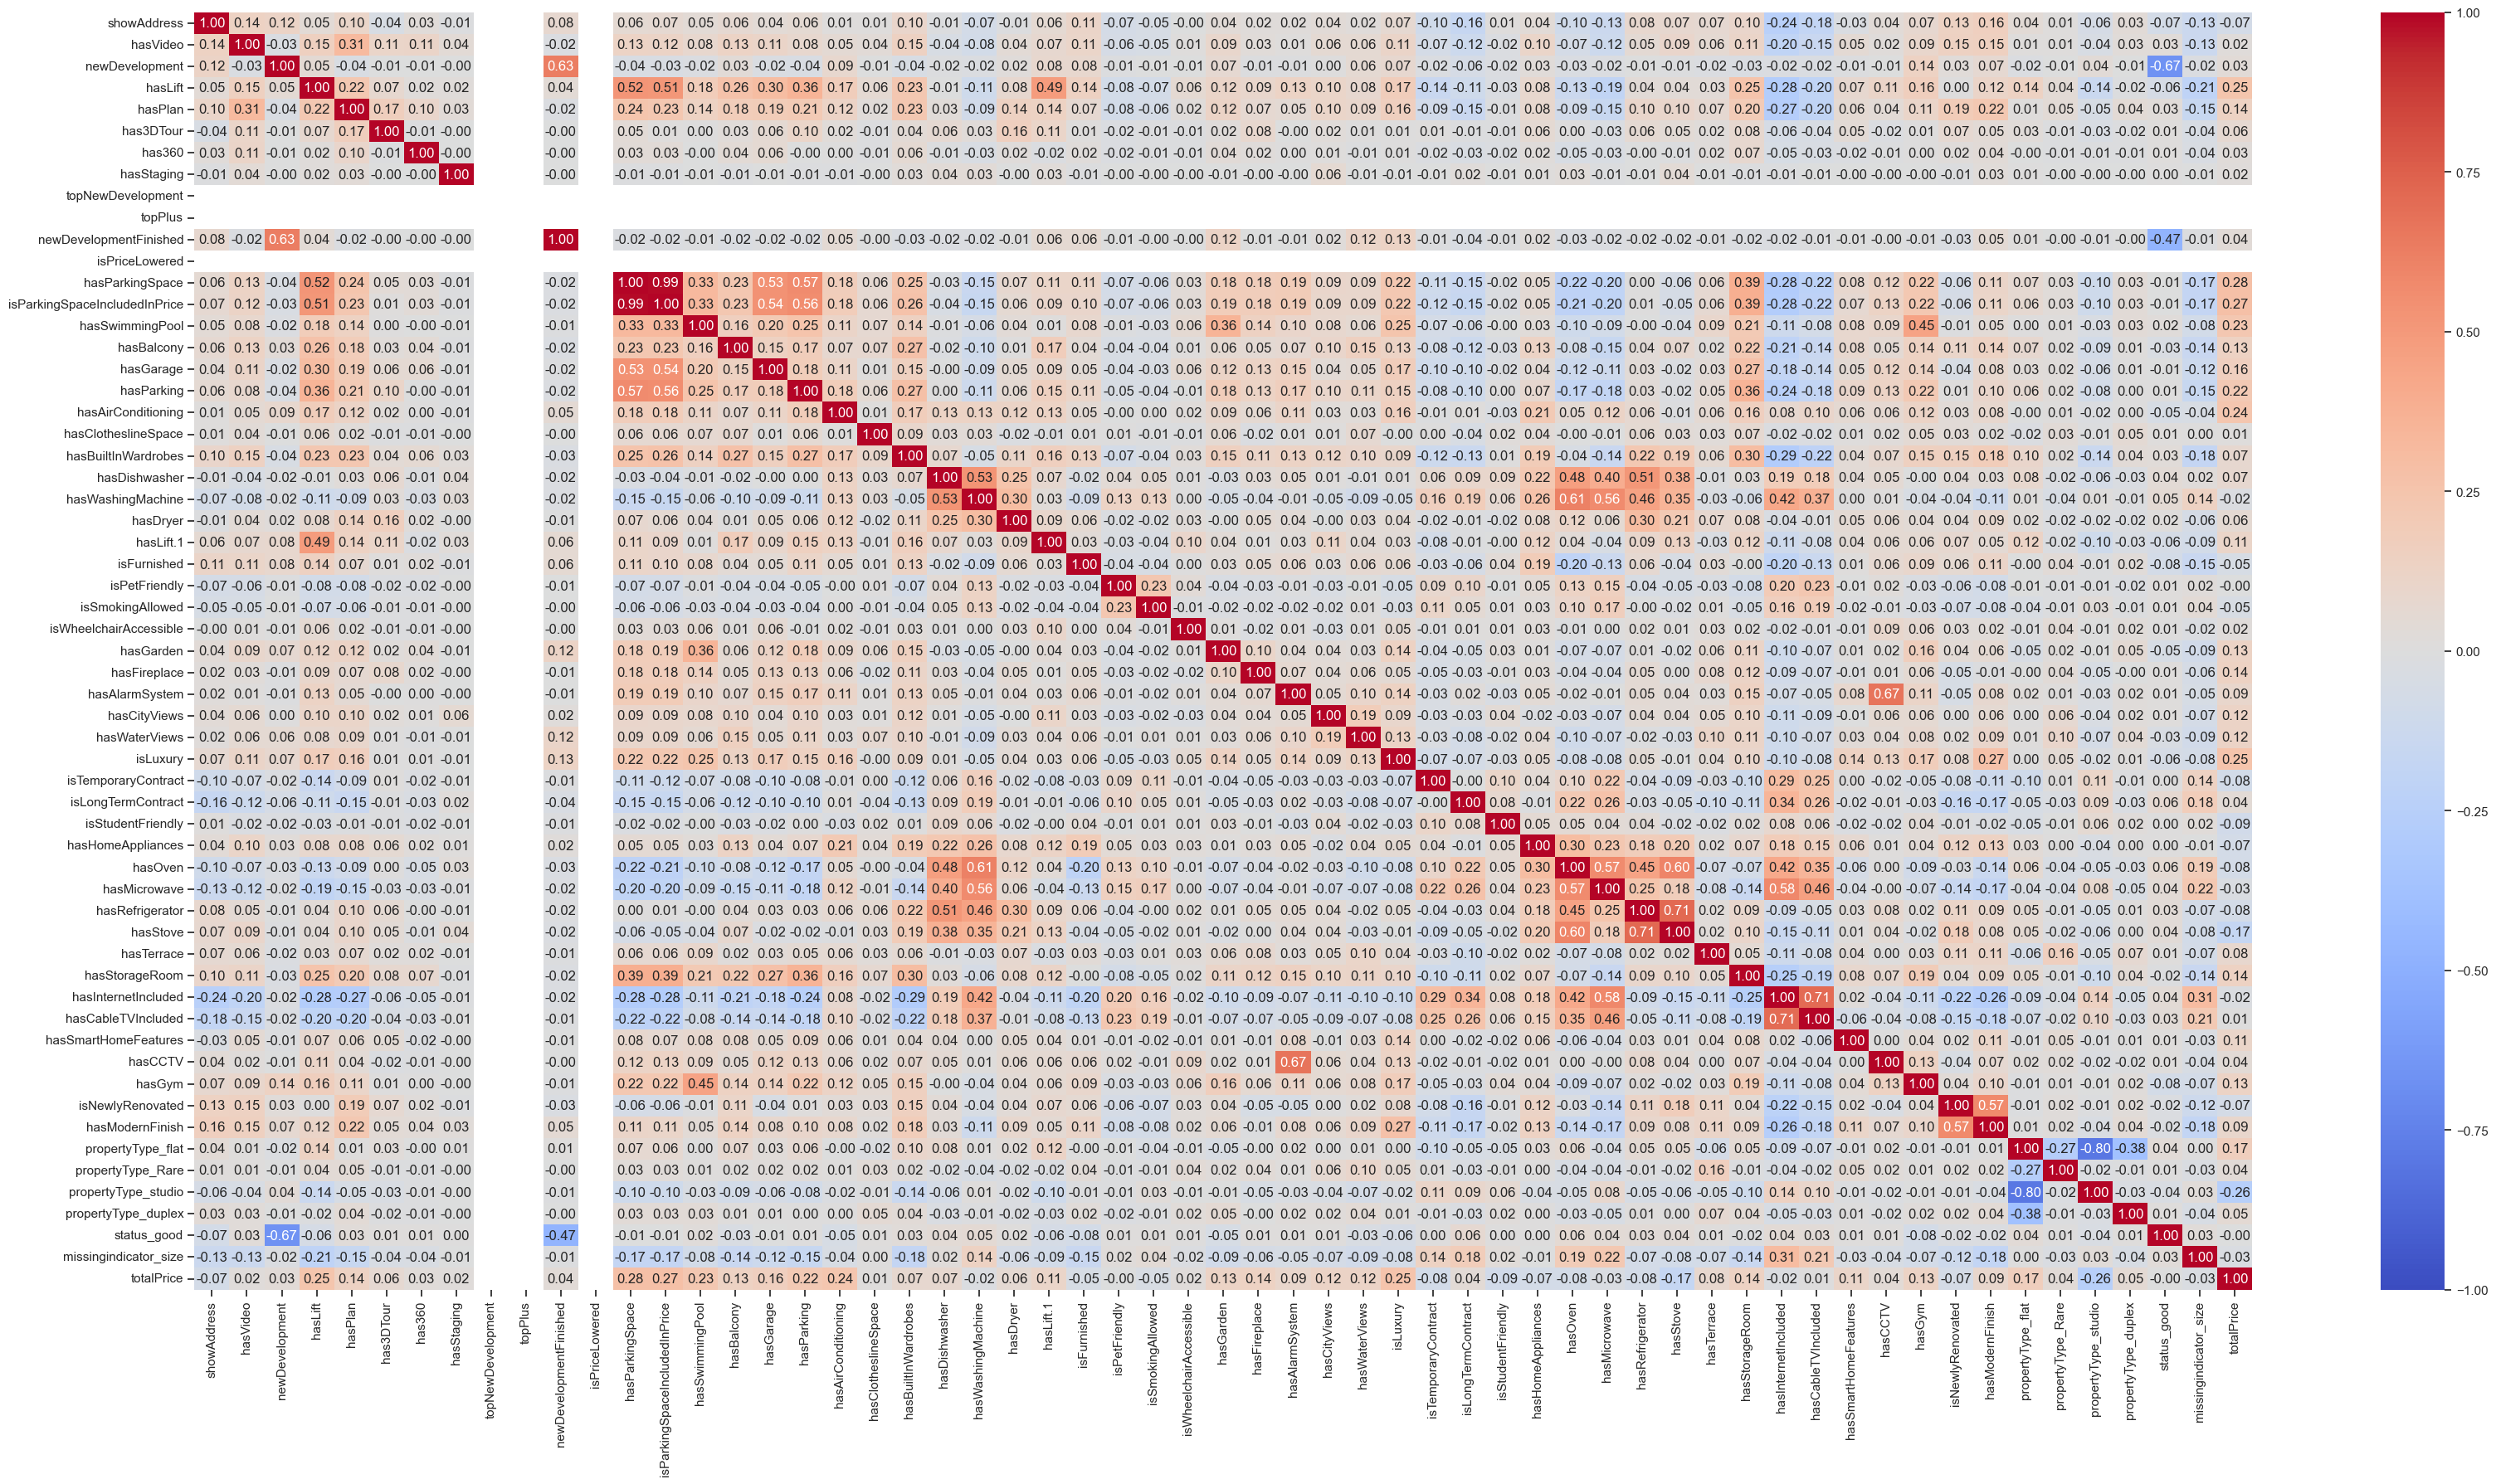

In [100]:
plt.figure(figsize=(40, 20))
sns.heatmap(
    data_train[binary_vars + target].corr(numeric_only=True),
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    vmax=1,
    vmin=-1,
)
plt.show()

In [86]:
temp = data_train.copy()
temp = temp.drop(columns=target)
all(temp.columns == features)

True

In [87]:
X_train = data_train[features]
y_train = data_train[target]

In [88]:
X_train_dev, X_val, y_train_dev, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

In [89]:
from sklearn.linear_model import LinearRegression

# set up the model
lin_model = LinearRegression()

# train the model
lin_model.fit(X_train_dev, y_train_dev)

y_pred_dev = lin_model.predict(X_train_dev)
y_pred_val = lin_model.predict(X_val)

In [90]:
from sklearn.metrics import root_mean_squared_error, r2_score

# evaluate the model
root_mean_squared_error(y_train_dev, y_pred_dev), r2_score(y_train_dev, y_pred_dev)

(0.5455220426478158, 0.6820877221868937)

In [91]:
root_mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val)

(0.5667539445777969, 0.6250783180282278)

In [92]:
def plot_performance(model, X_train, y_train, X_test, y_test):
    # Define the range of the dependent variable
    y_train_min, y_train_max = y_train.values.min(), y_train.values.max()
    y_test_min, y_test_max = y_test.values.min(), y_test.values.max()
    var_range = [min(y_train_min, y_test_min), max(y_train_max, y_test_max)]
        
    # Predict on training and test data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Plot actual vs predicted values
    plt.figure(figsize=(12, 4))
    
    # Plot train data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, color='royalblue', alpha=0.5, label='Train data')
    plt.plot(var_range, var_range, 'k--', lw=2)
    plt.xlabel(f'Actual price')
    plt.xlim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.ylabel(f'Predicted price')
    plt.ylim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.text(var_range[0], var_range[1] - 0.5, "RMSE = {:.3f}".format(root_mean_squared_error(y_train, y_train_pred)))
    plt.text(var_range[0], var_range[1] - 1, "R² = {:.3f}".format(r2_score(y_train, y_train_pred)))
    plt.legend(loc="lower right")
    
    # Plot test data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_test_pred, color='lightskyblue', alpha=0.5, label='Test data')
    plt.plot(var_range, var_range, 'k--', lw=2)
    plt.xlabel(f'Actual price')
    plt.xlim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.ylabel(f'Predicted price')
    plt.ylim(var_range[0] - 0.5, var_range[1] + 0.5)
    plt.text(var_range[0], var_range[1] - 0.5, "RMSE = {:.3f}".format(root_mean_squared_error(y_test, y_test_pred)))
    plt.text(var_range[0], var_range[1] - 1, "R² = {:.3f}".format(r2_score(y_test, y_test_pred)))
    plt.legend(loc="lower right")
    
    plt.show()

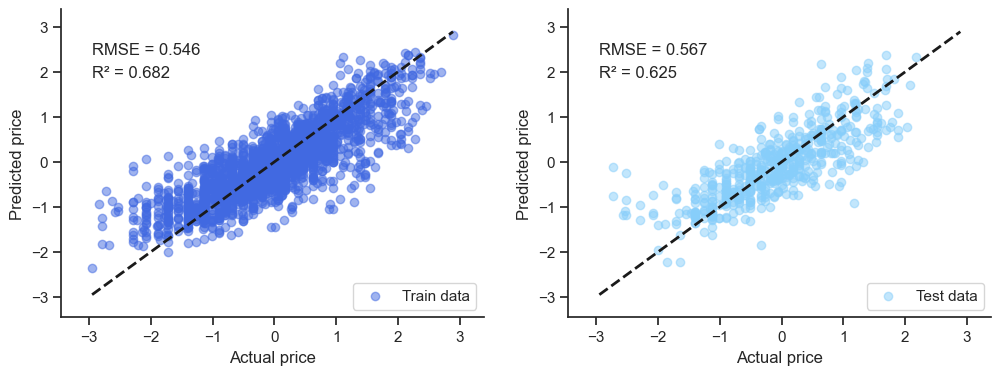

In [93]:
plot_performance(lin_model, X_train_dev, y_train_dev, X_val, y_val)

In [94]:
from sklearn.linear_model import ElasticNet

# set up the model
en_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42)

# train the model
en_model.fit(X_train_dev, y_train_dev)

y_pred_dev = en_model.predict(X_train_dev)
y_pred_val = en_model.predict(X_val)

In [95]:
root_mean_squared_error(y_train_dev, y_pred_dev), r2_score(y_train_dev, y_pred_dev)

(0.5570089097286903, 0.6685584298839402)

In [96]:
root_mean_squared_error(y_val, y_pred_val), r2_score(y_val, y_pred_val)

(0.571213732539567, 0.619154583448859)

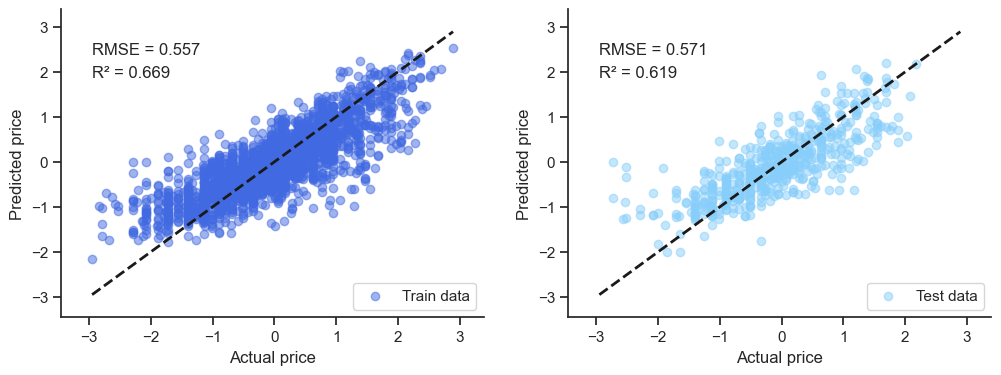

In [97]:
plot_performance(en_model, X_train_dev, y_train_dev, X_val, y_val)

# Additional Resources

- [Feature Engineering for Machine Learning](https://www.trainindata_train.com/p/feature-engineering-for-machine-learning) - Online Course
- [Packt Feature Engineering Cookbook](https://www.amazon.com/Python-Feature-Engineering-Cookbook-transforming-dp-1804611301/dp/1804611301) - Book
- [Predict house price with Feature-engine](https://www.kaggle.com/solegalli/predict-house-price-with-feature-engine) - Kaggle kernel
- [Comprehensive data exploration with Python](https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python) - Kaggle kernel
- [How I made top 0.3% on a Kaggle competition](https://www.kaggle.com/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition) - Kaggle kernel